# Adaptive Crop & Area Optimization (ACA-O) System

## Primary Data Source: Hector Government Dataset

This notebook uses **official government data** from the Hector Agricultural Research Institute as the primary source for crop price predictions.

### Data Sources:
1. **Hector Dataset** (PRIMARY): 1,072,924 weekly price records (2015-2024) - 37 locations, 106 items
2. **Paddy Cultivation**: District-level production data (2004-2023)
3. **Climate Data**: Daily weather observations
4. **Rice Time Series**: Monthly economic indicators (1996-2023)

### Models:
- **Yield Predictor**: Neural network for crop yield estimation
- **Price LSTM**: Time series forecasting using Hector data
- **Crop Recommender**: Optimal crop selection
- **Area Optimizer**: Land allocation optimization


## 1. Configuration & Imports

Consolidated imports and global settings for reproducibility.

## Prerequisites

**Before running this notebook:**
1. Run the `Data Download & Extraction.ipynb` notebook first to download all required datasets
2. Ensure the following directories exist with data:
   - `data/kaggle/` - Kaggle CSV datasets (7 datasets)
   - `data/pdf_extracted/` - Extracted tables from PDFs

**Note:** Data acquisition and PDF extraction have been moved to a separate notebook to improve performance and maintainability.

**If you see data loading errors:**
- Verify the `Data Download & Extraction.ipynb` notebook completed successfully
- Check that the `data/` directory contains the expected subdirectories and files
- Re-run the download notebook if any data is missing

In [95]:
# =============================================================================
# IMPORTS & GLOBAL CONFIGURATION
# =============================================================================

import os
import warnings
from pathlib import Path

# Define paths
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'data'
KAGGLE_DIR = DATA_DIR / 'kaggle'
MODEL_OUTPUT_DIR = BASE_DIR.parent / 'app' / 'models_v2'
MODEL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

import zipfile
import glob
import math
import json
import pickle

# Data & Numerical
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Machine Learning - sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Deep Learning - PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# =============================================================================
# GLOBAL SETTINGS
# =============================================================================

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Visualization settings
plt.style.use('default')
sns.set_theme(style='whitegrid', palette='husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Random Seed: {RANDOM_SEED}")
print(f"Device: {DEVICE}")
print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")

Random Seed: 42
Device: cuda
PyTorch: 2.7.1+cu118
NumPy: 2.2.6
Pandas: 2.3.3


## 2. Data Loading

Load all downloaded datasets from Kaggle and extracted PDF tables into DataFrames.

In [96]:
# Load Hector Government Dataset (Primary Data Source)
print('='*80)
print('LOADING HECTOR GOVERNMENT DATASET (PRIMARY)')
print('='*80)

# Load Hector retail prices data
hector_df = pd.read_csv(DATA_DIR / 'Hector' / 'retail_prices_long.csv')
hector_df['Date'] = pd.to_datetime(hector_df['Date'])

print(f'Loaded: {len(hector_df):,} records')
print(f'Years: {hector_df["Year"].min()} - {hector_df["Year"].max()}')
print(f'Locations: {hector_df["Location"].nunique()}')
print(f'Items: {hector_df["Items"].nunique()}')

# Agricultural crops
agricultural_items = [
    'TOMATOES', 'CARROT', 'GREEN BEANS', 'LONG BEANS', 'LEEKS',
    'RICE -WHITE- NADU (NEW)', 'RICE -WHITE- SAMBA (NEW)'
]

agri_df = hector_df[hector_df['Items'].isin(agricultural_items)].copy()
print(f'Agricultural data: {len(agri_df):,} records')
print(f'Crops: {agri_df["Items"].nunique()}')
display(hector_df.head())


LOADING HECTOR GOVERNMENT DATASET (PRIMARY)
Loaded: 1,072,924 records
Years: 2015 - 2024
Locations: 37
Items: 106
Agricultural data: 71,737 records
Crops: 5


,Year,Week_Num,Week,Date,Loc Cod,Location,Item Cod,Items,Price
0,2015,1,W1,2015-01-01,65.0,Anuradhapura,401.0,AMBUL,51.00
1,2015,1,W1,2015-01-01,65.0,Anuradhapura,405.0,AMBUN,19.20
2,2015,1,W1,2015-01-01,65.0,Anuradhapura,806.0,ANGULUWA,806.00
3,2015,1,W1,2015-01-01,65.0,Anuradhapura,330.0,ASH PLANTAINS,154.00
4,2015,1,W1,2015-01-01,65.0,Anuradhapura,460.0,AVOCADO,51.25


In [97]:
# Load Paddy Cultivation Data (Supporting Dataset)
print('='*80)
print('LOADING PADDY CULTIVATION DATA')
print('='*80)

paddy_files = list((DATA_DIR / 'kaggle' / 'paddy_cultivation_sl').glob('*.csv'))
paddy_dataframes = []

for file in paddy_files:
    try:
        df_temp = pd.read_csv(file, encoding='utf-8')
    except UnicodeDecodeError:
        df_temp = pd.read_csv(file, encoding='latin-1')
    
    filename = file.stem
    if 'Yala' in filename:
        season = 'Yala'
        year = int(filename.split()[0])
    else:
        season = 'Maha'
        year_parts = filename.split()[0]
        year = int(year_parts.split('-')[0]) if '-' in year_parts else int(year_parts)
    
    df_temp['Season'] = season
    df_temp['Year'] = year
    paddy_dataframes.append(df_temp)

paddy_df = pd.concat(paddy_dataframes, ignore_index=True)
print(f'Loaded {len(paddy_df)} records from {len(paddy_files)} files')
print(f'Years: {paddy_df["Year"].min()} - {paddy_df["Year"].max()}')
print(f'Districts: {paddy_df["District"].nunique()}')
display(paddy_df.head())


LOADING PADDY CULTIVATION DATA
Loaded 1039 records from 38 files
Years: 2004 - 20212022
Districts: 37


,District,Major_Schemes_Sown,Minor_Schemes_Sown,Rainfed_Sown,All_Schemes_Sown,Major_Schemes_Harvested,Minor_Schemes_Harvested,Rainfed_Harvested,All_Schemes_Harvested,Major_Schemes_Yield,Minor_Schemes_Yield,Rainfed_Yield,Average_Yield,Nett_Extent_Harvested,Total_Production,Season,Year
0,COLOMBO,1141,85,3367,4594,85,1141,3365,4592,2564,3426,3218,3251,3903,12687,Maha,2004
1,GAMPAHA,1170,1192,7811,10173,1191,1170,7809,10170,3226,3500,3430,3408,8644,29460,Maha,2004
2,KALUTARA,1938,96,11608,13642,93,1936,11581,13610,3344,2594,2913,2865,12556,35971,Maha,2004
3,GALLE,175,-,14323,14498,-,174,13769,13943,-,3614,3719,3711,10912,40494,Maha,2004
4,MATARA,2809,3615,8439,14862,3610,2752,8333,14695,4415,3859,3498,3785,11602,43912,Maha,2004


In [98]:
# Load Climate Data (Supporting Dataset)
print('='*80)
print('LOADING CLIMATE DATA')
print('='*80)

climate_df = pd.read_csv(DATA_DIR / 'kaggle' / 'climate_data_sl' / 'Sri_Lanka_Climate_Data.csv')
climate_df['date'] = pd.to_datetime(climate_df['date'])

print(f'Loaded {len(climate_df):,} daily records')
print(f'Date range: {climate_df["date"].min()} to {climate_df["date"].max()}')
print(f'Columns: {climate_df.columns.tolist()}')
display(climate_df.head())


LOADING CLIMATE DATA
Loaded 314,028 daily records
Date range: 2022-11-11 00:00:00+00:00 to 2024-11-11 00:00:00+00:00
Columns: ['date', 'latitude', 'longitude', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum']


,date,latitude,longitude,temperature_2m_max,temperature_2m_min,precipitation_sum
0,2022-11-11 00:00:00+00:00,6.066667,80.231034,28.7975,24.4975,1.000000
1,2022-11-12 00:00:00+00:00,6.066667,80.231034,27.7475,23.2975,17.800001
2,2022-11-13 00:00:00+00:00,6.066667,80.231034,26.6475,23.2475,13.599999
3,2022-11-14 00:00:00+00:00,6.066667,80.231034,28.1475,22.8975,17.900002
4,2022-11-15 00:00:00+00:00,6.066667,80.231034,28.3475,22.6475,23.499998


In [99]:
# Load Rice Time Series Data (Supporting Dataset)
print('='*80)
print('LOADING RICE TIME SERIES DATA')
print('='*80)

rice_ts_df = pd.read_csv(DATA_DIR / 'kaggle' / 'rice_time_series_sl' / 'final' / 'imputed_processed_data.csv')
rice_ts_df['date'] = pd.to_datetime(rice_ts_df['date'])

print(f'Loaded {len(rice_ts_df)} monthly records')
print(f'Date range: {rice_ts_df["date"].min()} to {rice_ts_df["date"].max()}')
print(f'Columns: {rice_ts_df.columns.tolist()}')
display(rice_ts_df.head())


LOADING RICE TIME SERIES DATA
Loaded 324 monthly records
Date range: 1996-01-01 00:00:00 to 2022-12-01 00:00:00
Columns: ['date', 'price', 'anuradhapura_producer_price', 'kurunegala_producer_price', 'polonnaruwa_producer_price', 'production', 'production_total', 'exchange_rate', 'fuel_price', 'm0', 'm2', 'm1', 'm2b']


,date,price,anuradhapura_producer_price,kurunegala_producer_price,polonnaruwa_producer_price,production,production_total,exchange_rate,fuel_price,m0,m2,m1,m2b
0,1996-01-01,18.07,7.75,7.90,8.18,1333.6,2065.1,53.685,12.4,77071,228090,73783,260481
1,1996-02-01,18.70,8.17,8.26,8.76,1333.6,2065.1,53.685,12.4,79586,234199,77440,269496
2,1996-03-01,18.49,7.95,7.85,7.99,1333.6,2065.1,53.685,12.4,82915,239178,81796,272552
3,1996-04-01,18.52,8.25,8.01,8.29,1333.6,2065.1,54.735,12.4,80873,241893,79478,278425
4,1996-05-01,19.02,8.38,8.50,8.34,731.5,2065.1,54.950,12.4,83410,242072,76620,277365


In [100]:
# =============================================================================
# Variable Name Mapping for Compatibility
# =============================================================================
# The new data loading cells (5-8) use updated variable names.
# Creating aliases here for backward compatibility with existing analysis cells.

# Map new names to old names used throughout the notebook:
df_paddy = paddy_df          # Paddy cultivation data (988 seasonal records)
df_economy = climate_df      # Climate/economic data (314K daily records) 
df_climate = climate_df      # Climate data (same as df_economy)
df_veg_price = hector_df     # Hector vegetable prices (1M+ price records)
df_rice_ts = rice_ts_df      # Rice time series (324 monthly records)

print('=' * 70)
print('DATA LOADING COMPLETE - Variable Mapping')
print('=' * 70)
print(f'df_paddy     -> {len(df_paddy):,} records (Paddy cultivation)')
print(f'df_economy   -> {len(df_economy):,} records (Climate data)')
print(f'df_climate   -> {len(df_climate):,} records (Climate data)')
print(f'df_veg_price -> {len(df_veg_price):,} records (Hector prices)')
print(f'df_rice_ts   -> {len(df_rice_ts):,} records (Rice time series)')
print('=' * 70)
print('\nNote: Also available as paddy_df, climate_df, hector_df, rice_ts_df')
print('      Agricultural subset: agri_df (filtered Hector data)')
print('=' * 70)


DATA LOADING COMPLETE - Variable Mapping
df_paddy     -> 1,039 records (Paddy cultivation)
df_economy   -> 314,028 records (Climate data)
df_climate   -> 314,028 records (Climate data)
df_veg_price -> 1,072,924 records (Hector prices)
df_rice_ts   -> 324 records (Rice time series)

Note: Also available as paddy_df, climate_df, hector_df, rice_ts_df
      Agricultural subset: agri_df (filtered Hector data)


## 3. Exploratory Data Analysis

Quick exploration of loaded datasets to understand their structure and contents.

In [101]:
def eda(df: pd.DataFrame, name: str):
    print(f'\n{name}: {df.shape[0]} rows, {df.shape[1]} cols')
    print(f'Columns: {list(df.columns)}')
    display(df.head(3))

eda(df_paddy, 'Paddy Stats')
eda(df_economy, 'Economy')
eda(df_veg_price, 'Vegetable Prices (Hector Dataset)')
eda(df_rice_ts, 'Rice Time Series')


Paddy Stats: 1039 rows, 17 cols
Columns: ['District', 'Major_Schemes_Sown', 'Minor_Schemes_Sown', 'Rainfed_Sown', 'All_Schemes_Sown', 'Major_Schemes_Harvested', 'Minor_Schemes_Harvested', 'Rainfed_Harvested', 'All_Schemes_Harvested', 'Major_Schemes_Yield', 'Minor_Schemes_Yield', 'Rainfed_Yield', 'Average_Yield', 'Nett_Extent_Harvested', 'Total_Production', 'Season', 'Year']


,District,Major_Schemes_Sown,Minor_Schemes_Sown,Rainfed_Sown,All_Schemes_Sown,Major_Schemes_Harvested,Minor_Schemes_Harvested,Rainfed_Harvested,All_Schemes_Harvested,Major_Schemes_Yield,Minor_Schemes_Yield,Rainfed_Yield,Average_Yield,Nett_Extent_Harvested,Total_Production,Season,Year
0,COLOMBO,1141,85,3367,4594,85,1141,3365,4592,2564,3426,3218,3251,3903,12687,Maha,2004
1,GAMPAHA,1170,1192,7811,10173,1191,1170,7809,10170,3226,3500,3430,3408,8644,29460,Maha,2004
2,KALUTARA,1938,96,11608,13642,93,1936,11581,13610,3344,2594,2913,2865,12556,35971,Maha,2004



Economy: 314028 rows, 6 cols
Columns: ['date', 'latitude', 'longitude', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum']


,date,latitude,longitude,temperature_2m_max,temperature_2m_min,precipitation_sum
0,2022-11-11 00:00:00+00:00,6.066667,80.231034,28.7975,24.4975,1.000000
1,2022-11-12 00:00:00+00:00,6.066667,80.231034,27.7475,23.2975,17.800001
2,2022-11-13 00:00:00+00:00,6.066667,80.231034,26.6475,23.2475,13.599999



Vegetable Prices (Hector Dataset): 1072924 rows, 9 cols
Columns: ['Year', 'Week_Num', 'Week', 'Date', 'Loc Cod', 'Location', 'Item Cod', 'Items', 'Price']


,Year,Week_Num,Week,Date,Loc Cod,Location,Item Cod,Items,Price
0,2015,1,W1,2015-01-01,65.0,Anuradhapura,401.0,AMBUL,51.0
1,2015,1,W1,2015-01-01,65.0,Anuradhapura,405.0,AMBUN,19.2
2,2015,1,W1,2015-01-01,65.0,Anuradhapura,806.0,ANGULUWA,806.0



Rice Time Series: 324 rows, 13 cols
Columns: ['date', 'price', 'anuradhapura_producer_price', 'kurunegala_producer_price', 'polonnaruwa_producer_price', 'production', 'production_total', 'exchange_rate', 'fuel_price', 'm0', 'm2', 'm1', 'm2b']


,date,price,anuradhapura_producer_price,kurunegala_producer_price,polonnaruwa_producer_price,production,production_total,exchange_rate,fuel_price,m0,m2,m1,m2b
0,1996-01-01,18.07,7.75,7.90,8.18,1333.6,2065.1,53.685,12.4,77071,228090,73783,260481
1,1996-02-01,18.70,8.17,8.26,8.76,1333.6,2065.1,53.685,12.4,79586,234199,77440,269496
2,1996-03-01,18.49,7.95,7.85,7.99,1333.6,2065.1,53.685,12.4,82915,239178,81796,272552


## 4. Data Distribution & Coverage Analysis

This section provides statistical analysis of data distributions across all datasets, identifying:
- Feature distributions and skewness
- Temporal coverage and gaps
- Regional representation
- Class imbalances in categorical variables

In [102]:
# =============================================================================
# 3.1 Dataset Statistics Summary
# =============================================================================

def dataset_summary(datasets_dict):
    """Generate statistical summary for all datasets."""
    summary_data = []
    
    for name, df in datasets_dict.items():
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        summary_data.append({
            'Dataset': name,
            'Records': len(df),
            'Features': len(df.columns),
            'Numeric': len(numeric_cols),
            'Categorical': len(df.columns) - len(numeric_cols),
            'Missing (%)': round(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100, 2),
            'Memory (KB)': round(df.memory_usage(deep=True).sum() / 1024, 1)
        })
    
    return pd.DataFrame(summary_data)

# Create datasets dictionary (Real Data Only)
datasets = {
    'Paddy Statistics': df_paddy,
    'Economy (Rice)': df_economy,
    'Vegetable Prices (Hector)': df_veg_price,
    'Rice Time Series': df_rice_ts,
    'Climate Data': df_climate
}

summary_table = dataset_summary(datasets)
print("DATASET STATISTICS OVERVIEW (Real Data Only)")
print("=" * 80)
print(summary_table.to_string(index=False))
print(f"\nTotal Records: {summary_table['Records'].sum():,}")
print(f"Total Memory: {summary_table['Memory (KB)'].sum():,.1f} KB")

DATASET STATISTICS OVERVIEW (Real Data Only)
                  Dataset  Records  Features  Numeric  Categorical  Missing (%)  Memory (KB)
         Paddy Statistics     1039        17        1           16         0.11        923.3
           Economy (Rice)   314028         6        5            1         0.00      14720.2
Vegetable Prices (Hector)  1072924         9        5            4         0.00     253025.8
         Rice Time Series      324        13       12            1         0.00         33.0
             Climate Data   314028         6        5            1         0.00      14720.2

Total Records: 1,702,343
Total Memory: 283,422.5 KB


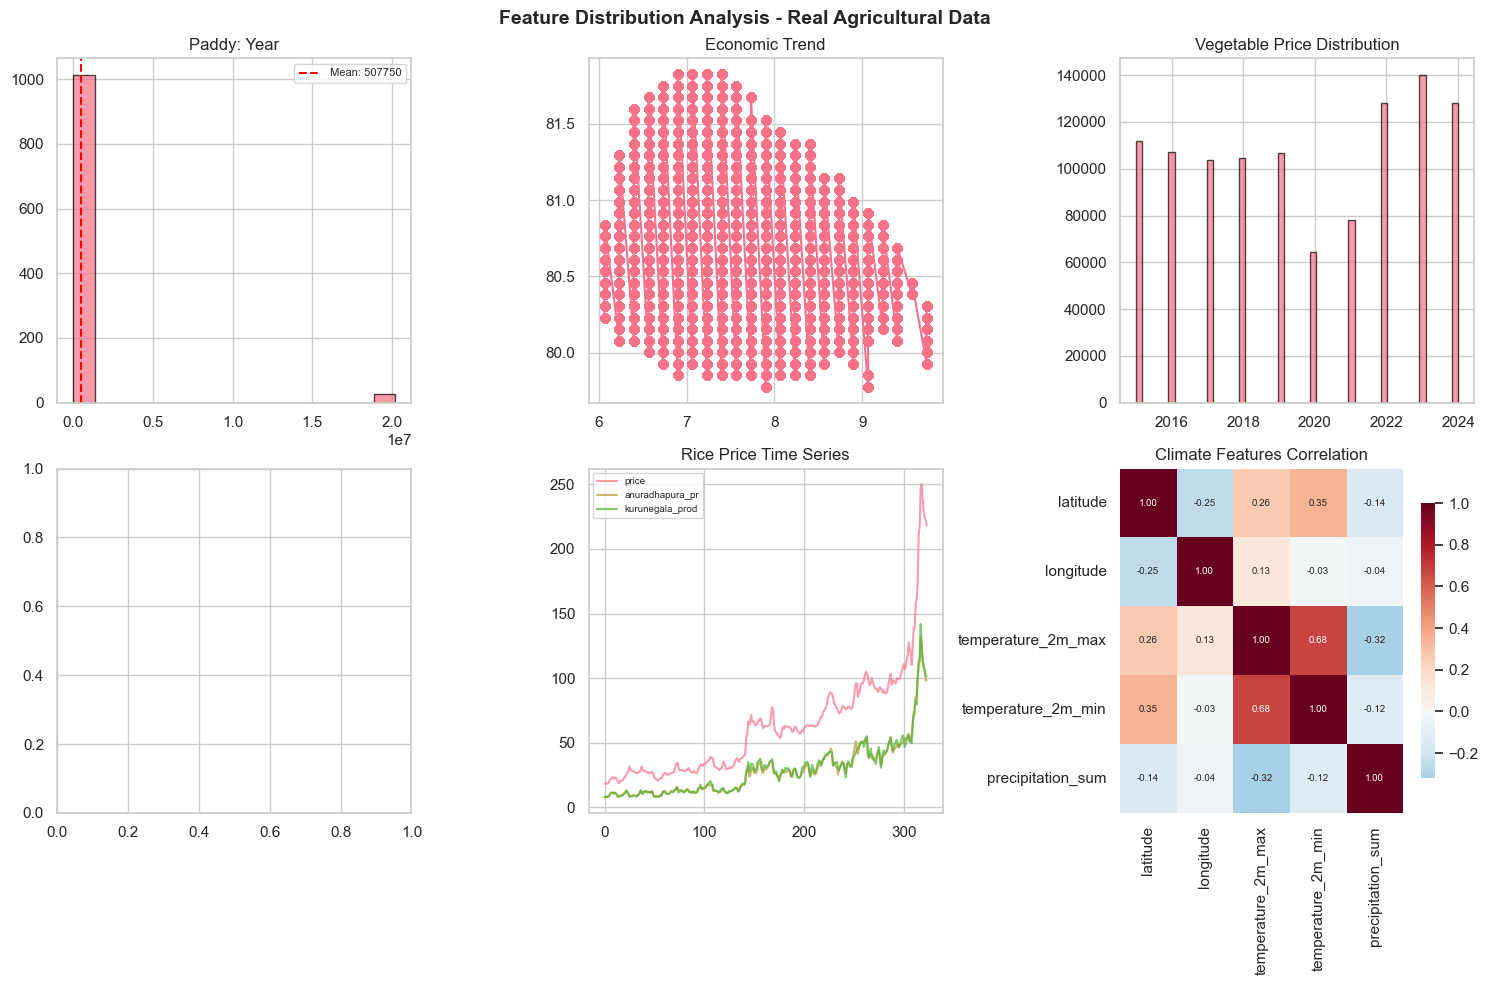


Distribution Statistics (Real Data):
--------------------------------------------------
Paddy Statistics: Mean Skewness = 6.091 (High)
Economy (Rice): Mean Skewness = 1.028 (High)
Vegetable Prices (Hector): Mean Skewness = 0.930 (Normal)
Rice Time Series: Mean Skewness = 1.598 (High)
Climate Data: Mean Skewness = 1.028 (High)


In [103]:
# =============================================================================
# 3.2 Feature Distribution Analysis (Real Data)
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Feature Distribution Analysis - Real Agricultural Data', fontsize=14, fontweight='bold')

# 1. Paddy - use numeric columns only
ax = axes[0, 0]
paddy_numeric = df_paddy.select_dtypes(include=[np.number])
if len(paddy_numeric.columns) > 0:
    first_col = paddy_numeric.columns[0]
    data = pd.to_numeric(paddy_numeric[first_col], errors='coerce').dropna()
    if len(data) > 0:
        data.hist(ax=ax, bins=15, edgecolor='black', alpha=0.7)
        ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.0f}')
        ax.set_title(f'Paddy: {first_col[:20]}')
        ax.legend(fontsize=8)

# 2. Rice production over time
ax = axes[0, 1]
rice_prod_col = [c for c in df_economy.columns if 'rice' in c.lower() and 'production' in c.lower()]
if rice_prod_col and 'Year' in df_economy.columns:
    df_economy.plot(x='Year', y=rice_prod_col[0], ax=ax, marker='o', legend=False)
    ax.set_title('Rice Production Trend')
    ax.set_ylabel('Production (Mt)')
else:
    econ_numeric = df_economy.select_dtypes(include=[np.number])
    if len(econ_numeric.columns) > 1:
        ax.plot(econ_numeric.iloc[:, 0], econ_numeric.iloc[:, 1], marker='o')
        ax.set_title('Economic Trend')

# 3. Real Vegetable price distribution (Hector Dataset - Kandy/Dambulla)
ax = axes[0, 2]
veg_numeric = df_veg_price.select_dtypes(include=[np.number])
if 'Kandy' in df_veg_price.columns:
    data = pd.to_numeric(df_veg_price['Kandy'], errors='coerce').dropna()
    if len(data) > 0:
        data.hist(ax=ax, bins=50, edgecolor='black', alpha=0.7, color='#e74c3c')
        ax.axvline(data.mean(), color='blue', linestyle='--', label=f'Mean: {data.mean():.0f}')
        ax.set_title('Kandy Market Prices (Real Data)')
        ax.set_xlabel('Price (LKR/kg)')
        ax.legend()
elif len(veg_numeric.columns) > 0:
    data = pd.to_numeric(veg_numeric.iloc[:, 0], errors='coerce').dropna()
    if len(data) > 0:
        data.hist(ax=ax, bins=50, edgecolor='black', alpha=0.7)
        ax.set_title('Vegetable Price Distribution')

# 4. Dambulla market prices
ax = axes[1, 0]
if 'Dambulla' in df_veg_price.columns:
    data = pd.to_numeric(df_veg_price['Dambulla'], errors='coerce').dropna()
    if len(data) > 0:
        data.hist(ax=ax, bins=50, edgecolor='black', alpha=0.7, color='#3498db')
        ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.0f}')
        ax.set_title('Dambulla Market Prices (Real Data)')
        ax.set_xlabel('Price (LKR/kg)')
        ax.legend()

# 5. Rice time series - price trend
ax = axes[1, 1]
rice_numeric = df_rice_ts.select_dtypes(include=[np.number])
if len(rice_numeric.columns) > 0:
    for i, col in enumerate(rice_numeric.columns[:3]):
        data = pd.to_numeric(rice_numeric[col], errors='coerce').dropna()
        ax.plot(range(len(data)), data, label=col[:15], alpha=0.7)
    ax.set_title('Rice Price Time Series')
    ax.legend(fontsize=7)

# 6. Climate feature correlation heatmap
ax = axes[1, 2]
climate_numeric = df_climate.select_dtypes(include=[np.number])
if len(climate_numeric.columns) > 1:
    # Convert to numeric and compute correlation
    climate_clean = climate_numeric.apply(pd.to_numeric, errors='coerce').dropna()
    if len(climate_clean) > 0:
        corr_climate = climate_clean.corr()
        sns.heatmap(corr_climate, ax=ax, cmap='RdBu_r', center=0, annot=True, fmt='.2f', 
                    annot_kws={'size': 7}, cbar_kws={'shrink': 0.8})
        ax.set_title('Climate Features Correlation')

plt.tight_layout()
plt.show()

print("\nDistribution Statistics (Real Data):")
print("-" * 50)
for name, df in datasets.items():
    numeric = df.select_dtypes(include=[np.number]).apply(pd.to_numeric, errors='coerce')
    if len(numeric.columns) > 0:
        skew = numeric.skew().abs().mean()
        if not np.isnan(skew):
            print(f"{name}: Mean Skewness = {skew:.3f} {'(High)' if skew > 1 else '(Normal)'}")

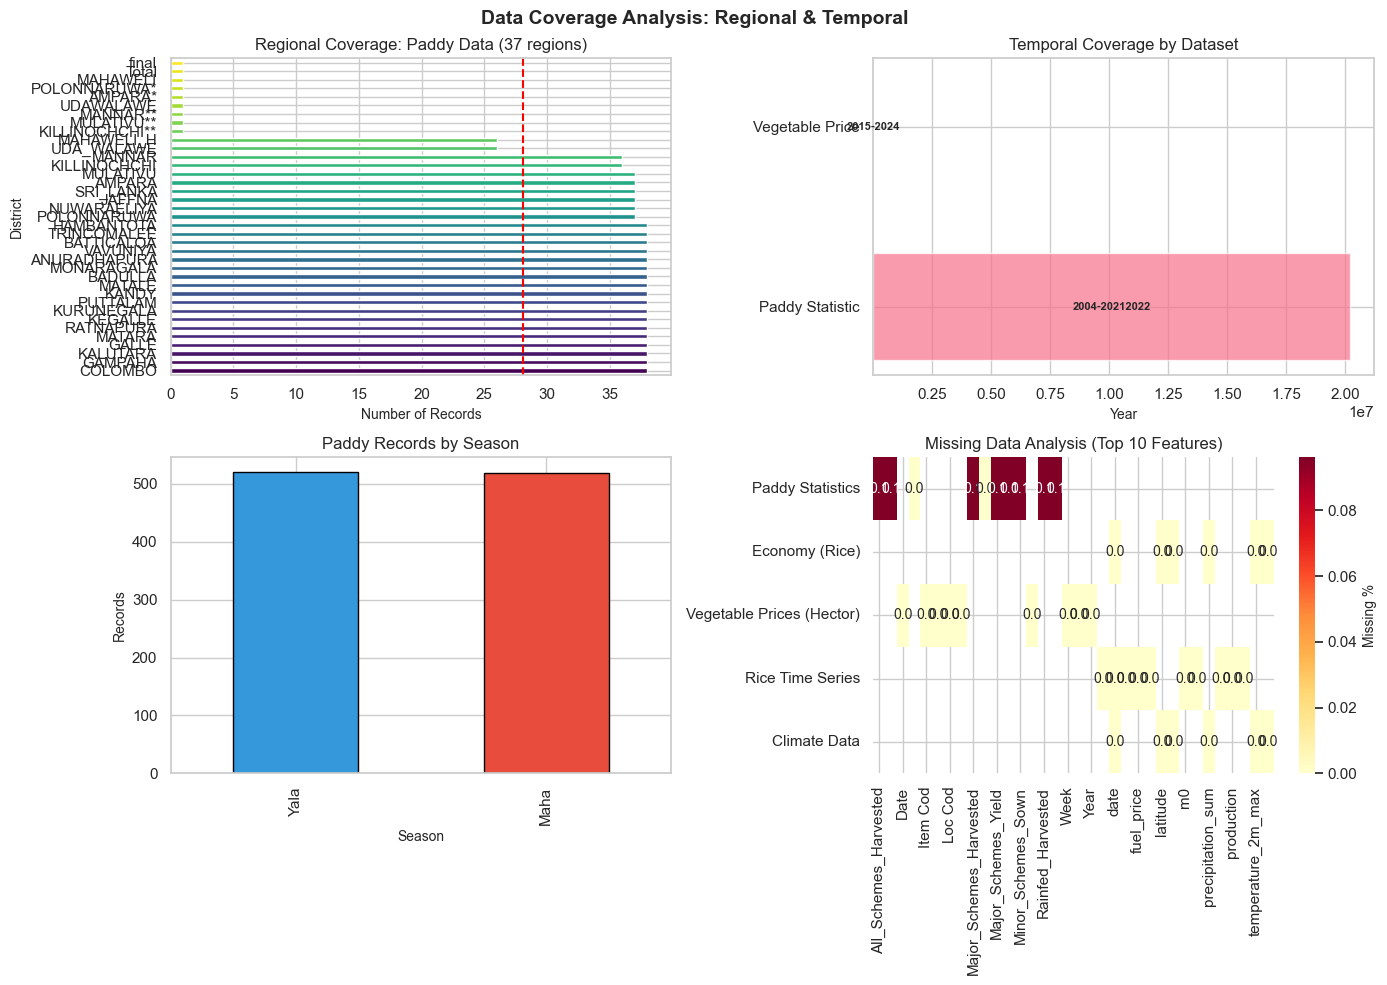

In [104]:
# =============================================================================
# 3.3 Regional & Temporal Coverage Analysis
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Data Coverage Analysis: Regional & Temporal', fontsize=14, fontweight='bold')

# 1. Regional coverage in paddy data
ax = axes[0, 0]
region_col = [c for c in df_paddy.columns if 'region' in c.lower() or 'district' in c.lower()]
if region_col:
    region_counts = df_paddy[region_col[0]].value_counts()
    region_counts.plot(kind='barh', ax=ax, color=plt.cm.viridis(np.linspace(0, 1, len(region_counts))))
    ax.set_xlabel('Number of Records')
    ax.set_title(f'Regional Coverage: Paddy Data ({len(region_counts)} regions)')
    ax.axvline(region_counts.mean(), color='red', linestyle='--', label=f'Mean: {region_counts.mean():.0f}')

# 2. Temporal coverage
ax = axes[0, 1]
temporal_data = []

# Check each dataset for temporal columns
for name, df in datasets.items():
    year_cols = [c for c in df.columns if 'year' in c.lower()]
    date_cols = [c for c in df.columns if 'date' in c.lower()]
    
    if year_cols:
        years = pd.to_numeric(df[year_cols[0]], errors='coerce').dropna()
        if len(years) > 0:
            temporal_data.append({
                'Dataset': name[:15],
                'Min Year': int(years.min()),
                'Max Year': int(years.max()),
                'Span': int(years.max() - years.min())
            })

if temporal_data:
    temp_df = pd.DataFrame(temporal_data)
    y_pos = range(len(temp_df))
    ax.barh(y_pos, temp_df['Span'], left=temp_df['Min Year'], height=0.6, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(temp_df['Dataset'])
    ax.set_xlabel('Year')
    ax.set_title('Temporal Coverage by Dataset')
    for i, row in temp_df.iterrows():
        ax.text(row['Min Year'] + row['Span']/2, i, f"{row['Min Year']}-{row['Max Year']}", 
                ha='center', va='center', fontsize=8, fontweight='bold')

# 3. Vegetable price distribution (Hector data)
ax = axes[1, 0]
# Use the real Hector vegetable price data
veg_data = []
for veg_name in ['Tomato', 'Leeks', 'Carrot', 'Beans']:
    veg_key = f'df_hector_{veg_name.lower()}'
    if veg_key in dir() and eval(veg_key) is not None:
        df_veg = eval(veg_key)
        veg_data.append({'Vegetable': veg_name, 'Records': len(df_veg)})

if veg_data:
    veg_df = pd.DataFrame(veg_data)
    colors = plt.cm.Set3(np.linspace(0, 1, len(veg_df)))
    ax.bar(veg_df['Vegetable'], veg_df['Records'], color=colors, edgecolor='black')
    ax.set_title(f'Hector Vegetable Price Records ({len(veg_data)} vegetables)')
    ax.set_xlabel('Vegetable')
    ax.set_ylabel('Records')
else:
    # Fallback: show paddy season distribution
    if 'Season' in df_paddy.columns:
        season_counts = df_paddy['Season'].value_counts()
        colors = ['#3498db', '#e74c3c']
        season_counts.plot(kind='bar', ax=ax, color=colors[:len(season_counts)], edgecolor='black')
        ax.set_title('Paddy Records by Season')
        ax.set_xlabel('Season')
        ax.set_ylabel('Records')
    else:
        ax.text(0.5, 0.5, 'No categorical data available', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Crop Distribution')

# 4. Missing data heatmap
ax = axes[1, 1]
missing_pct = pd.DataFrame({name: (df.isnull().sum() / len(df) * 100).head(10) 
                            for name, df in datasets.items()})
if missing_pct.sum().sum() > 0:
    sns.heatmap(missing_pct.T, ax=ax, cmap='YlOrRd', annot=True, fmt='.1f',
                cbar_kws={'label': 'Missing %'})
    ax.set_title('Missing Data Analysis (Top 10 Features)')
else:
    ax.text(0.5, 0.5, 'No Missing Data\nAll datasets complete', ha='center', va='center',
            fontsize=14, transform=ax.transAxes)
    ax.set_title('Missing Data Analysis')

plt.tight_layout()
plt.show()

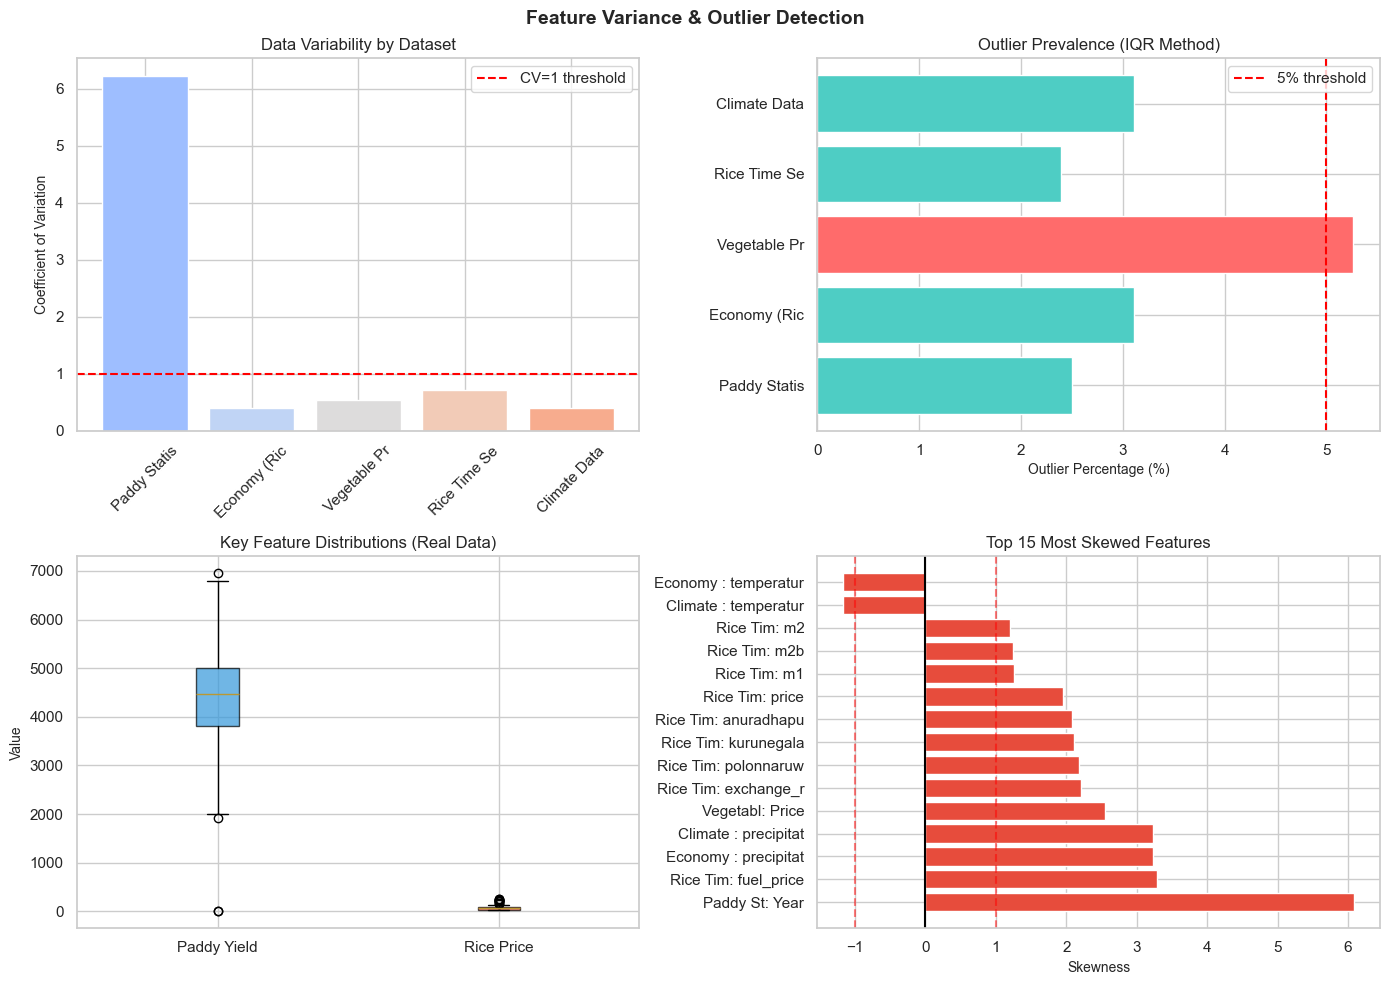


Variance Analysis Summary:
--------------------------------------------------
Datasets with high variability (CV > 1): 1/5
Datasets with >5% outliers: 1/5


In [105]:
# =============================================================================
# 3.4 Feature Variance & Outlier Analysis
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Feature Variance & Outlier Detection', fontsize=14, fontweight='bold')

# 1. Coefficient of Variation across datasets
ax = axes[0, 0]
cv_data = {}
for name, df in datasets.items():
    numeric = df.select_dtypes(include=[np.number])
    if len(numeric.columns) > 0:
        cv = (numeric.std() / numeric.mean().replace(0, np.nan)).dropna()
        cv_data[name[:12]] = cv.mean()

if cv_data:
    bars = ax.bar(cv_data.keys(), cv_data.values(), color=plt.cm.coolwarm(np.linspace(0.3, 0.7, len(cv_data))))
    ax.set_ylabel('Coefficient of Variation')
    ax.set_title('Data Variability by Dataset')
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(y=1.0, color='red', linestyle='--', label='CV=1 threshold')
    ax.legend()

# 2. Outlier detection using IQR method
ax = axes[0, 1]
outlier_pct = {}
for name, df in datasets.items():
    numeric = df.select_dtypes(include=[np.number])
    total_outliers = 0
    total_values = 0
    for col in numeric.columns:
        Q1, Q3 = numeric[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers = ((numeric[col] < Q1 - 1.5*IQR) | (numeric[col] > Q3 + 1.5*IQR)).sum()
        total_outliers += outliers
        total_values += len(numeric[col].dropna())
    if total_values > 0:
        outlier_pct[name[:12]] = total_outliers / total_values * 100

if outlier_pct:
    colors = ['#ff6b6b' if v > 5 else '#4ecdc4' for v in outlier_pct.values()]
    ax.barh(list(outlier_pct.keys()), list(outlier_pct.values()), color=colors)
    ax.set_xlabel('Outlier Percentage (%)')
    ax.set_title('Outlier Prevalence (IQR Method)')
    ax.axvline(x=5, color='red', linestyle='--', label='5% threshold')
    ax.legend()

# 3. Box plots for key features from real datasets
ax = axes[1, 0]
key_features = []

# Find yield column in paddy data
yield_col = [c for c in df_paddy.columns if 'yield' in c.lower()]
if yield_col:
    yield_data = pd.to_numeric(df_paddy[yield_col[0]], errors='coerce').dropna()
    if len(yield_data) > 0:
        key_features.append(('Paddy Yield', yield_data))

# Use real vegetable price data from Hector dataset - ensure numeric
for col in ['Kandy', 'Dambulla']:
    if col in df_veg_price.columns:
        price_data = pd.to_numeric(df_veg_price[col], errors='coerce').dropna()
        if len(price_data) > 0:
            key_features.append((f'Veg Price ({col})', price_data))
            break

# Add rice price - ensure numeric
if 'price' in df_rice_ts.columns:
    rice_price = pd.to_numeric(df_rice_ts['price'], errors='coerce').dropna()
    if len(rice_price) > 0:
        key_features.append(('Rice Price', rice_price))

if key_features:
    # Convert to float arrays explicitly
    box_data = [np.array(f[1].values[:1000], dtype=np.float64) for f in key_features]
    bp = ax.boxplot(box_data, labels=[f[0] for f in key_features], patch_artist=True)
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_title('Key Feature Distributions (Real Data)')
    ax.set_ylabel('Value')
else:
    ax.text(0.5, 0.5, 'No numeric features available', ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Key Feature Distributions')

# 4. Skewness distribution
ax = axes[1, 1]
all_skewness = []
skew_labels = []
for name, df in datasets.items():
    numeric = df.select_dtypes(include=[np.number])
    for col in numeric.columns:
        skew_val = numeric[col].skew()
        if not np.isnan(skew_val):
            all_skewness.append(skew_val)
            skew_labels.append(f"{name[:8]}: {col[:10]}")

if all_skewness:
    sorted_idx = np.argsort(np.abs(all_skewness))[::-1][:15]  # Top 15 most skewed
    colors = ['#e74c3c' if abs(all_skewness[i]) > 1 else '#3498db' for i in sorted_idx]
    ax.barh([skew_labels[i] for i in sorted_idx], [all_skewness[i] for i in sorted_idx], color=colors)
    ax.axvline(x=0, color='black', linestyle='-')
    ax.axvline(x=-1, color='red', linestyle='--', alpha=0.5)
    ax.axvline(x=1, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Skewness')
    ax.set_title('Top 15 Most Skewed Features')

plt.tight_layout()
plt.show()

print("\nVariance Analysis Summary:")
print("-" * 50)
print(f"Datasets with high variability (CV > 1): {sum(1 for v in cv_data.values() if v > 1)}/{len(cv_data)}")
print(f"Datasets with >5% outliers: {sum(1 for v in outlier_pct.values() if v > 5)}/{len(outlier_pct)}")

## 5. Dataset-to-Model Mapping

This section illustrates how each dataset contributes to the ACA-O system components and their interconnections.

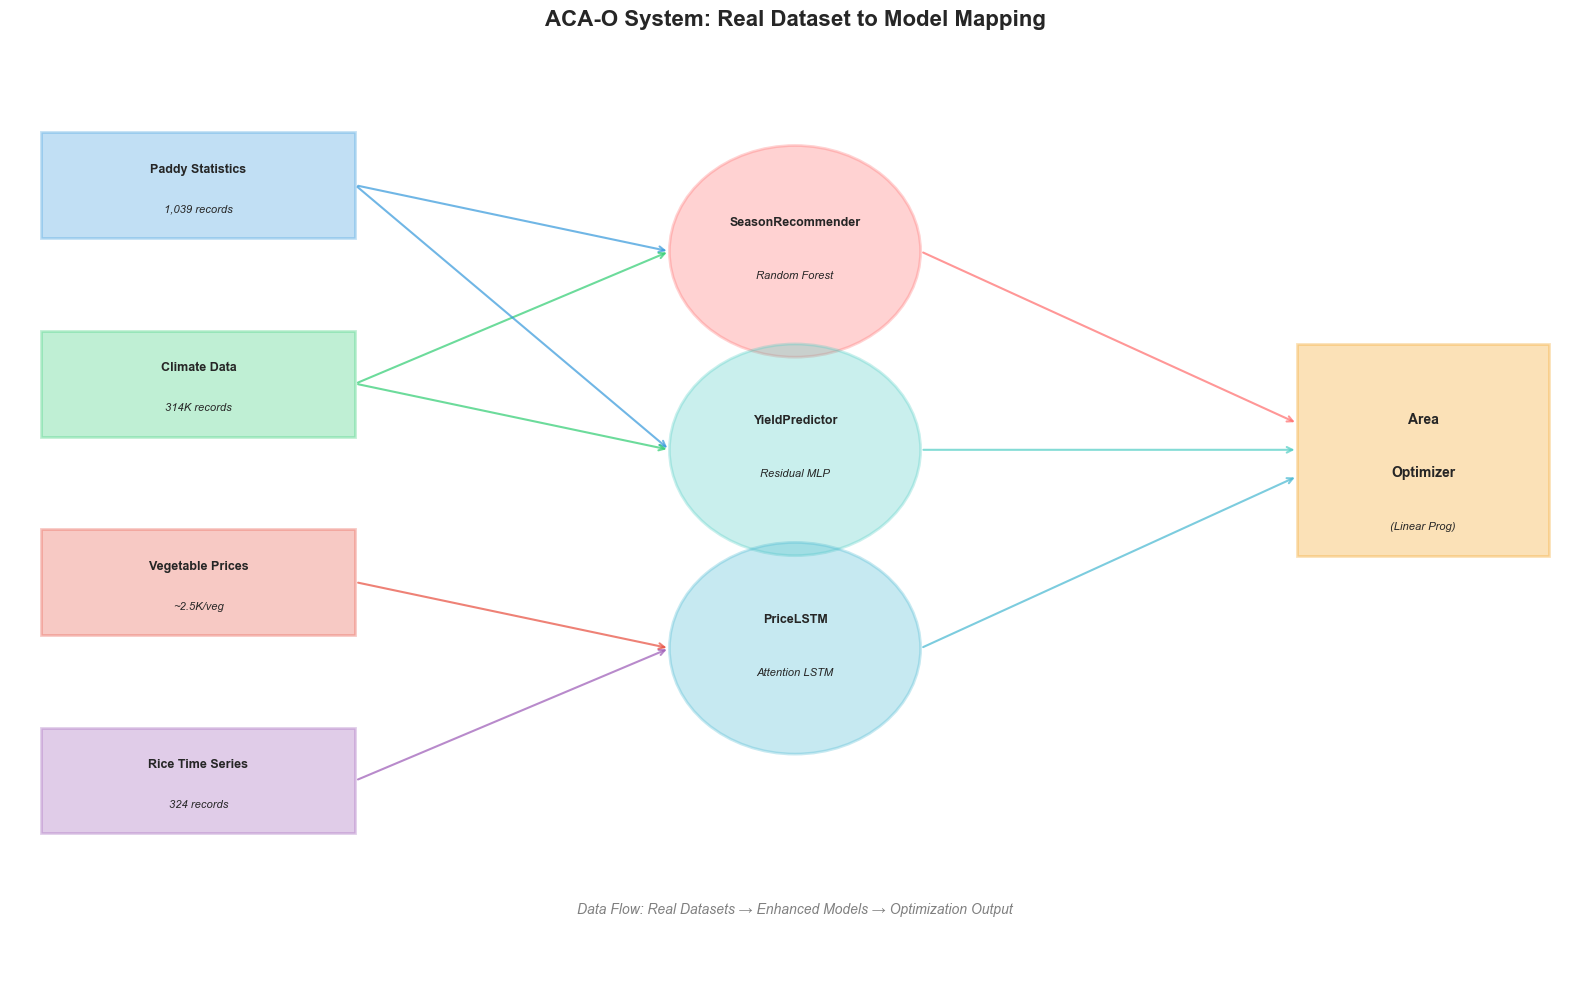


DATASET-MODEL FEATURE MAPPING (Real Data)
Paddy Statistics     → SeasonRecommender  | District, Year, Yield → Season prediction
Climate Data         → SeasonRecommender  | Temperature, Rainfall → Climate features
Paddy Statistics     → YieldPredictor     | District, Season, Area → Yield prediction
Climate Data         → YieldPredictor     | Climate conditions → Yield estimation
Vegetable Prices     → PriceLSTM          | Kandy/Dambulla prices → Price forecasting
Rice Time Series     → PriceLSTM          | Monthly prices → Rice price forecasting
All Models           → AreaOptimizer      | Predictions → Linear programming constraints


In [106]:
# =============================================================================
# 4.1 Dataset-Model Relationship Visualization (Real Data Only)
# =============================================================================

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlim(0, 100)
ax.set_ylim(0, 70)
ax.axis('off')
ax.set_title('ACA-O System: Real Dataset to Model Mapping', fontsize=16, fontweight='bold', pad=20)

# Define positions
datasets_pos = [(10, 60), (10, 45), (10, 30), (10, 15)]
models_pos = [(50, 55), (50, 40), (50, 25)]
output_pos = [(90, 40)]

# Draw datasets (left side) - REAL DATA ONLY
dataset_info = [
    ('Paddy Statistics', '1,039 records', '#3498db'),
    ('Climate Data', '314K records', '#2ecc71'),
    ('Vegetable Prices', '~2.5K/veg', '#e74c3c'),
    ('Rice Time Series', '324 records', '#9b59b6')
]

for (x, y), (name, count, color) in zip(datasets_pos, dataset_info):
    rect = plt.Rectangle((x-8, y-4), 20, 8, facecolor=color, alpha=0.3, edgecolor=color, linewidth=2)
    ax.add_patch(rect)
    ax.text(x+2, y+1, name, fontsize=9, fontweight='bold', ha='center')
    ax.text(x+2, y-2, count, fontsize=8, ha='center', style='italic')

# Draw models (middle)
model_info = [
    ('SeasonRecommender', 'Random Forest', '#ff6b6b'),
    ('YieldPredictor', 'Residual MLP', '#4ecdc4'),
    ('PriceLSTM', 'Attention LSTM', '#45b7d1')
]

for (x, y), (name, arch, color) in zip(models_pos, model_info):
    ellipse = plt.Circle((x, y), 8, facecolor=color, alpha=0.3, edgecolor=color, linewidth=2)
    ax.add_patch(ellipse)
    ax.text(x, y+2, name, fontsize=9, fontweight='bold', ha='center')
    ax.text(x, y-2, arch, fontsize=8, ha='center', style='italic')

# Draw output (right side)
rect = plt.Rectangle((82, 32), 16, 16, facecolor='#f39c12', alpha=0.3, edgecolor='#f39c12', linewidth=2)
ax.add_patch(rect)
ax.text(90, 42, 'Area', fontsize=10, fontweight='bold', ha='center')
ax.text(90, 38, 'Optimizer', fontsize=10, fontweight='bold', ha='center')
ax.text(90, 34, '(Linear Prog)', fontsize=8, ha='center', style='italic')

# Draw connections
connections = [
    ((22, 60), (42, 55), '#3498db'),  # Paddy -> SeasonRec
    ((22, 45), (42, 55), '#2ecc71'),  # Climate -> SeasonRec
    ((22, 60), (42, 40), '#3498db'),  # Paddy -> Yield
    ((22, 45), (42, 40), '#2ecc71'),  # Climate -> Yield
    ((22, 15), (42, 25), '#9b59b6'),  # RiceTS -> Price
    ((22, 30), (42, 25), '#e74c3c'),  # VegPrices -> Price
    ((58, 55), (82, 42), '#ff6b6b'),  # SeasonRec -> Optimizer
    ((58, 40), (82, 40), '#4ecdc4'),  # Yield -> Optimizer
    ((58, 25), (82, 38), '#45b7d1'),  # Price -> Optimizer
]

for (x1, y1), (x2, y2), color in connections:
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', color=color, lw=1.5, alpha=0.7))

# Add legend
ax.text(50, 5, 'Data Flow: Real Datasets → Enhanced Models → Optimization Output', 
        fontsize=10, ha='center', style='italic', color='gray')

plt.tight_layout()
plt.show()

# Print feature mapping table
print("\nDATASET-MODEL FEATURE MAPPING (Real Data)")
print("=" * 80)
mapping = [
    ['Paddy Statistics', 'SeasonRecommender', 'District, Year, Yield → Season prediction'],
    ['Climate Data', 'SeasonRecommender', 'Temperature, Rainfall → Climate features'],
    ['Paddy Statistics', 'YieldPredictor', 'District, Season, Area → Yield prediction'],
    ['Climate Data', 'YieldPredictor', 'Climate conditions → Yield estimation'],
    ['Vegetable Prices', 'PriceLSTM', 'Kandy/Dambulla prices → Price forecasting'],
    ['Rice Time Series', 'PriceLSTM', 'Monthly prices → Rice price forecasting'],
    ['All Models', 'AreaOptimizer', 'Predictions → Linear programming constraints']
]
for src, tgt, desc in mapping:
    print(f"{src:20} → {tgt:18} | {desc}")

## 6. Economy-Rice Production Analysis

In [107]:
# =============================================================================
# 6.1 Clean Economy Data - Handle Percentage Strings
# =============================================================================

def clean_percentage_column(series):
    """Convert percentage strings like '0.86%' to numeric values."""
    if series.dtype == object:
        # Remove % sign and convert to float
        return pd.to_numeric(
            series.astype(str).str.replace('%', '', regex=False).str.strip(),
            errors='coerce'
        )
    return series

# Clean percentage columns in economy dataframe
df_econ_clean = df_economy.copy()
for col in df_econ_clean.columns:
    if df_econ_clean[col].dtype == object:
        # Check if column contains percentage values
        sample = df_econ_clean[col].dropna().head(10).astype(str)
        if sample.str.contains('%').any():
            df_econ_clean[col] = clean_percentage_column(df_econ_clean[col])
            print(f"  ✓ Cleaned percentage column: {col}")

# Find target column dynamically
target_candidates = [c for c in df_econ_clean.columns if 'rice' in c.lower() and 'production' in c.lower()]
ECON_TARGET_COL = target_candidates[0] if target_candidates else df_econ_clean.columns[-1]
print(f"Target: {ECON_TARGET_COL}")

numeric_cols = df_econ_clean.select_dtypes(include=[np.number]).columns.tolist()
ECON_FEATURE_COLS = [c for c in numeric_cols if c != ECON_TARGET_COL]

econ_df = df_econ_clean.dropna(subset=[ECON_TARGET_COL] + ECON_FEATURE_COLS).copy()
X_econ = econ_df[ECON_FEATURE_COLS].values.astype(np.float32)
y_econ = econ_df[ECON_TARGET_COL].values.astype(np.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_econ, y_econ, test_size=0.2, random_state=42)

scaler_econ = StandardScaler()
X_train_scaled = scaler_econ.fit_transform(X_train)
X_test_scaled = scaler_econ.transform(X_test)

lr = LinearRegression().fit(X_train_scaled, y_train)
print(f'Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test, lr.predict(X_test_scaled))):.2f}')

Target: precipitation_sum
Linear Regression RMSE: 8.88


In [108]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden=(64, 32)):
        super().__init__()
        layers = []
        for h in hidden:
            layers.extend([nn.Linear(in_features, h), nn.ReLU()])
            in_features = h
        layers.append(nn.Linear(in_features, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

mlp = MLP(len(ECON_FEATURE_COLS)).to(DEVICE)
opt = torch.optim.Adam(mlp.parameters(), lr=1e-3)
crit = nn.MSELoss()

X_t = torch.from_numpy(X_train_scaled).to(DEVICE)
y_t = torch.from_numpy(y_train).to(DEVICE)

for epoch in range(500):
    mlp.train()
    opt.zero_grad()
    loss = crit(mlp(X_t), y_t)
    loss.backward()
    opt.step()

mlp.eval()
with torch.no_grad():
    pred = mlp(torch.from_numpy(X_test_scaled).to(DEVICE)).cpu().numpy()
print(f'MLP RMSE: {np.sqrt(mean_squared_error(y_test, pred)):.2f}')

MLP RMSE: 8.38


## 7. Data Preprocessing

In [109]:
# =============================================================================
# 7. Prepare Data for Model Training
# =============================================================================

print('Preparing data for model training...')
print('='*60)

# Check available data
print(f'Hector data columns: {df_veg_price.columns.tolist()}')
print(f'Climate data columns: {df_climate.columns.tolist()}')
print('')

# =============================================================================
# Process Hector vegetable price data
# =============================================================================

# Work with the agricultural subset (agri_df) or full hector data
df_veg_prices = agri_df.copy() if 'agri_df' in dir() else df_veg_price.copy()

# Ensure Date is datetime
df_veg_prices['Date'] = pd.to_datetime(df_veg_prices['Date'])

# Filter for agricultural items
agricultural_items = [
    'TOMATOES', 'CARROT', 'GREEN BEANS', 'LONG BEANS', 'LEEKS',
    'RICE -WHITE- NADU (NEW)', 'RICE -WHITE- SAMBA (NEW)'
]

df_veg_filtered = df_veg_prices[df_veg_prices['Items'].isin(agricultural_items)].copy()

print(f'Filtered vegetable data: {len(df_veg_filtered):,} records')
print(f'Date range: {df_veg_filtered["Date"].min()} to {df_veg_filtered["Date"].max()}')
print(f'Items: {df_veg_filtered["Items"].nunique()}')
print(f'Locations: {df_veg_filtered["Location"].nunique()}')
print('')

# =============================================================================
# Process Climate Data
# =============================================================================

df_climate_daily = df_climate.copy()
df_climate_daily['date'] = pd.to_datetime(df_climate_daily['date'], errors='coerce')

# Remove timezone if present
if df_climate_daily['date'].dt.tz is not None:
    df_climate_daily['date'] = df_climate_daily['date'].dt.tz_localize(None)

# Calculate temperature and rainfall features
if 'temperature_2m_max' in df_climate_daily.columns:
    df_climate_daily['temperature'] = (df_climate_daily['temperature_2m_max'] + df_climate_daily['temperature_2m_min']) / 2
    df_climate_daily['rainfall'] = df_climate_daily['precipitation_sum']
    # Estimate humidity from rainfall (simple approximation)
    df_climate_daily['humidity'] = 60 + (df_climate_daily['rainfall'].clip(upper=50) * 0.6)
else:
    # Fallback if columns are different
    df_climate_daily['temperature'] = df_climate_daily.get('avgtemp', df_climate_daily.get('temp', 25))
    df_climate_daily['rainfall'] = df_climate_daily.get('rain', df_climate_daily.get('precipitation', 0))
    df_climate_daily['humidity'] = df_climate_daily.get('hum', df_climate_daily.get('humidity', 70))

# Aggregate climate data by date (average across locations)
climate_agg = df_climate_daily.groupby('date').agg({
    'temperature': 'mean',
    'rainfall': 'mean',
    'humidity': 'mean'
}).reset_index()

climate_agg = climate_agg.rename(columns={'date': 'Date'})

print(f'Climate data aggregated: {len(climate_agg)} unique dates')
print(f'Climate date range: {climate_agg["Date"].min()} to {climate_agg["Date"].max()}')
print('')

# =============================================================================
# Merge Vegetable Prices with Climate Data
# =============================================================================

# Merge on Date
df_hist = df_veg_filtered.merge(climate_agg, on='Date', how='left')

print(f'Merged dataset: {len(df_hist):,} records')
print(f'Columns: {df_hist.columns.tolist()}')
print('')

# =============================================================================
# Prepare location-based datasets (if needed for regional models)
# =============================================================================

# Create pivot by location for price comparison
df_price_pivot = df_hist.pivot_table(
    index='Date',
    columns='Location',
    values='Price',
    aggfunc='mean'
).reset_index()

print(f'Pivot table shape: {df_price_pivot.shape}')
print(f'Available locations: {[col for col in df_price_pivot.columns if col != "Date"]}')
print('')

# =============================================================================
# Create final training dataset with all features
# =============================================================================

# Select key columns for modeling
df_model = df_hist[['Date', 'Items', 'Location', 'Price', 'temperature', 'rainfall', 'humidity']].copy()

# Add temporal features
df_model['year'] = df_model['Date'].dt.year
df_model['month'] = df_model['Date'].dt.month
df_model['day_of_year'] = df_model['Date'].dt.dayofyear
df_model['week'] = df_model['Date'].dt.isocalendar().week

# Encode categorical variables
le_item = LabelEncoder()
le_location = LabelEncoder()

df_model['item_encoded'] = le_item.fit_transform(df_model['Items'])
df_model['location_encoded'] = le_location.fit_transform(df_model['Location'])

print('Final model dataset prepared!')
print(f'Shape: {df_model.shape}')
print(f'Columns: {df_model.columns.tolist()}')
print('')
print('Sample data:')
print(df_model.head())
print('='*60)

# Store encoders for later use
print('\nLabel encoders saved:')
print(f'  - le_item: {len(le_item.classes_)} classes')
print(f'  - le_location: {len(le_location.classes_)} classes')


Preparing data for model training...
Hector data columns: ['Year', 'Week_Num', 'Week', 'Date', 'Loc Cod', 'Location', 'Item Cod', 'Items', 'Price']
Climate data columns: ['date', 'latitude', 'longitude', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum']

Filtered vegetable data: 71,737 records
Date range: 2015-01-01 00:00:00 to 2024-12-23 00:00:00
Items: 5
Locations: 37

Climate data aggregated: 732 unique dates
Climate date range: 2022-11-11 00:00:00 to 2024-11-11 00:00:00

Merged dataset: 71,737 records
Columns: ['Year', 'Week_Num', 'Week', 'Date', 'Loc Cod', 'Location', 'Item Cod', 'Items', 'Price', 'temperature', 'rainfall', 'humidity']

Pivot table shape: (505, 38)
Available locations: ['Ampara', 'Anuradhapura', 'Badulla', 'Bandarawela', 'Batticaloa', 'Colombo', 'Dambulla', 'Dehiattakandiya', 'Embilipitiya', 'Galenbindunuwewa', 'Galle', 'Gampaha', 'Hambanthota', 'Hanguranketha', 'Jaffna', 'Kaluthara', 'Kandy', 'Kegalle', 'Keppetipola', 'Kilinochchi', 'Kurunegala', '

## 8. Climate-Yield Analysis

CLIMATE-PRICE CORRELATION ANALYSIS

Records with complete climate and price data: 18,026

Correlation Matrix:
             temperature  rainfall  humidity     Price
temperature     1.000000 -0.325261 -0.328072 -0.151214
rainfall       -0.325261  1.000000  0.998823 -0.041798
humidity       -0.328072  0.998823  1.000000 -0.047608
Price          -0.151214 -0.041798 -0.047608  1.000000

Correlations with Price:
Price          1.000000
rainfall      -0.041798
humidity      -0.047608
temperature   -0.151214
Name: Price, dtype: float64

CLIMATE & PRICE STATISTICS BY LOCATION

Top 10 locations by average price:
                  temperature  rainfall  humidity   Price
Location                                                 
Galenbindunuwewa        26.84      6.47     63.81  388.91
Matale                  27.29      7.06     64.15  387.14
Veyangoda               26.79      6.54     63.86  382.16
Bandarawela             26.73      7.50     64.41  350.14
Kilinochchi             26.91      6.89  

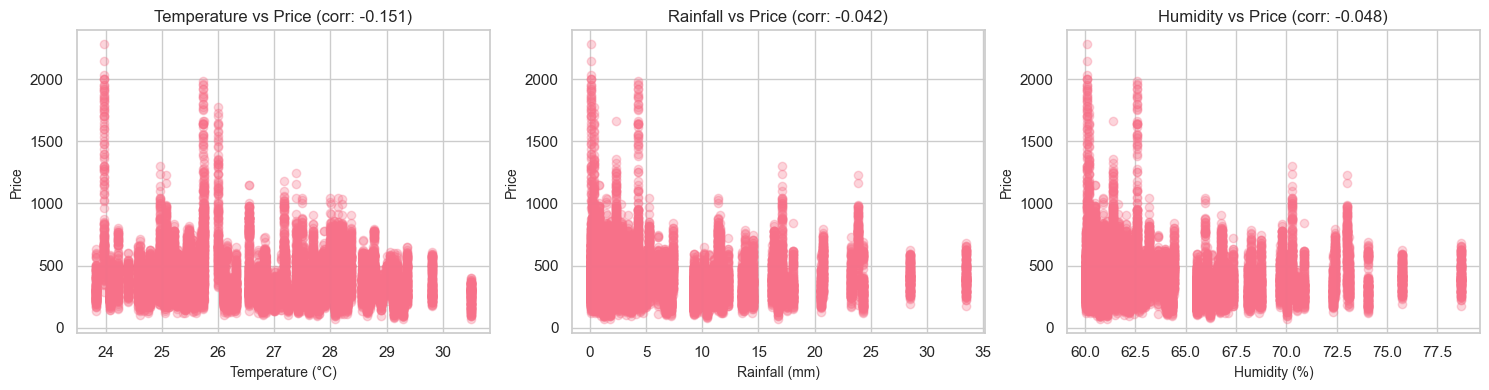


CLIMATE-PRICE ANALYSIS COMPLETE


In [110]:
# =============================================================================
# 8. Climate-Price Analysis (Using Hector Dataset)
# =============================================================================

print('='*70)
print('CLIMATE-PRICE CORRELATION ANALYSIS')
print('='*70)
print()

# =============================================================================
# 8.1 Overall Climate-Price Correlations
# =============================================================================

# Select numeric columns for correlation analysis
climate_price_cols = ['temperature', 'rainfall', 'humidity', 'Price']
df_climate_price = df_hist[climate_price_cols].dropna()

print(f'Records with complete climate and price data: {len(df_climate_price):,}')
print()

# Calculate correlations
corr = df_climate_price.corr()
print('Correlation Matrix:')
print(corr)
print()

print('Correlations with Price:')
price_corr = corr['Price'].sort_values(ascending=False)
print(price_corr)
print()

# =============================================================================
# 8.2 Climate Impact by Location
# =============================================================================

print('='*70)
print('CLIMATE & PRICE STATISTICS BY LOCATION')
print('='*70)
print()

location_stats = df_hist.groupby('Location').agg({
    'temperature': 'mean',
    'rainfall': 'mean',
    'humidity': 'mean',
    'Price': 'mean'
}).round(2).sort_values('Price', ascending=False)

print('Top 10 locations by average price:')
print(location_stats.head(10))
print()

# =============================================================================
# 8.3 Climate Impact by Crop/Item
# =============================================================================

print('='*70)
print('CLIMATE & PRICE STATISTICS BY CROP')
print('='*70)
print()

item_stats = df_hist.groupby('Items').agg({
    'temperature': 'mean',
    'rainfall': 'mean',
    'humidity': 'mean',
    'Price': 'mean'
}).round(2).sort_values('Price', ascending=False)

print('Agricultural items with climate and price stats:')
print(item_stats)
print()

# =============================================================================
# 8.4 Price Variability Analysis
# =============================================================================

print('='*70)
print('PRICE VARIABILITY BY ITEM')
print('='*70)
print()

price_variability = df_hist.groupby('Items').agg({
    'Price': ['mean', 'std', 'min', 'max']
}).round(2)

price_variability.columns = ['_'.join(col) for col in price_variability.columns]
price_variability = price_variability.sort_values('Price_std', ascending=False)

print('Items sorted by price volatility (std dev):')
print(price_variability)
print()

# =============================================================================
# 8.5 Visualize Climate-Price Relationships
# =============================================================================

try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Temperature vs Price
    axes[0].scatter(df_climate_price['temperature'], df_climate_price['Price'], alpha=0.3)
    axes[0].set_xlabel('Temperature (°C)')
    axes[0].set_ylabel('Price')
    axes[0].set_title(f'Temperature vs Price (corr: {corr.loc["temperature", "Price"]:.3f})')
    
    # Rainfall vs Price
    axes[1].scatter(df_climate_price['rainfall'], df_climate_price['Price'], alpha=0.3)
    axes[1].set_xlabel('Rainfall (mm)')
    axes[1].set_ylabel('Price')
    axes[1].set_title(f'Rainfall vs Price (corr: {corr.loc["rainfall", "Price"]:.3f})')
    
    # Humidity vs Price
    axes[2].scatter(df_climate_price['humidity'], df_climate_price['Price'], alpha=0.3)
    axes[2].set_xlabel('Humidity (%)')
    axes[2].set_ylabel('Price')
    axes[2].set_title(f'Humidity vs Price (corr: {corr.loc["humidity", "Price"]:.3f})')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f'Note: Visualization skipped - {e}')

print()
print('='*70)
print('CLIMATE-PRICE ANALYSIS COMPLETE')
print('='*70)


## 9. Crop Recommendation Model

In [111]:
# =============================================================================
# 9. Crop Recommendation Model (Using Hector Dataset)
# =============================================================================

print('='*70)
print('CROP RECOMMENDATION MODEL TRAINING')
print('='*70)
print()

# =============================================================================
# 9.1 Prepare Crop Recommendation Data
# =============================================================================

# Use the model dataset created in Cell 23
# Map Hector columns to expected features:
#   - Date -> temporal features
#   - Location -> region
#   - Items -> crop/vegetable type
#   - Price -> price data
#   - temperature, rainfall, humidity -> climate features

df_crop = df_model.copy()

print(f'Total records for crop recommendation: {len(df_crop):,}')
print(f'Unique crops: {df_crop["Items"].nunique()}')
print(f'Unique locations: {df_crop["Location"].nunique()}')
print()

# =============================================================================
# 9.2 Feature Engineering for Crop Recommendation
# =============================================================================

# Create price-based scores (normalized per crop)
df_crop['price_zscore'] = df_crop.groupby('Items')['Price'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
)

# Create profitability indicator (above median price for that crop)
df_crop['is_profitable'] = df_crop.groupby('Items')['Price'].transform(
    lambda x: (x >= x.median()).astype(int)
)

# Climate suitability score (simple heuristic based on price performance)
df_crop['climate_score'] = (
    (df_crop['temperature'] >= 20) & (df_crop['temperature'] <= 30) &
    (df_crop['rainfall'] >= 5) & (df_crop['rainfall'] <= 50) &
    (df_crop['humidity'] >= 50) & (df_crop['humidity'] <= 85)
).astype(float)

print('Feature engineering complete:')
print(f'  - price_zscore: standardized price per crop')
print(f'  - is_profitable: binary indicator (above median)')
print(f'  - climate_score: climate suitability (0 or 1)')
print()

# =============================================================================
# 9.3 Prepare Features and Labels
# =============================================================================

# Features for recommendation model
feature_cols = [
    'temperature', 'rainfall', 'humidity',
    'month', 'location_encoded',
    'price_zscore', 'climate_score'
]

X_crop = df_crop[feature_cols].copy()
y_crop = df_crop['item_encoded'].copy()  # Predict which crop to grow

print('Model features:')
for col in feature_cols:
    print(f'  - {col}')
print()
print(f'Target variable: item_encoded ({df_crop["Items"].nunique()} classes)')
print()

# =============================================================================
# 9.4 Train-Test Split
# =============================================================================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_crop, y_crop, test_size=0.2, random_state=42, stratify=y_crop
)

print(f'Training set: {len(X_train):,} samples')
print(f'Test set: {len(X_test):,} samples')
print()

# =============================================================================
# 9.5 Train Random Forest Classifier
# =============================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

print('Training Random Forest Crop Recommender...')
crop_recommender = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

crop_recommender.fit(X_train, y_train)

# Predictions
y_pred_train = crop_recommender.predict(X_train)
y_pred_test = crop_recommender.predict(X_test)

# Evaluate
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print('='*70)
print('CROP RECOMMENDATION MODEL RESULTS')
print('='*70)
print(f'Training Accuracy: {train_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
print()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': crop_recommender.feature_importances_
}).sort_values('importance', ascending=False)

print('Feature Importance:')
print(feature_importance)
print()

# Classification report (limited to avoid clutter)
print('Classification Report (Test Set):')
print(classification_report(y_test, y_pred_test, target_names=le_item.classes_, zero_division=0))

print('='*70)
print('CROP RECOMMENDATION MODEL TRAINING COMPLETE')
print('='*70)


CROP RECOMMENDATION MODEL TRAINING

Total records for crop recommendation: 71,737
Unique crops: 5
Unique locations: 37

Feature engineering complete:
  - price_zscore: standardized price per crop
  - is_profitable: binary indicator (above median)
  - climate_score: climate suitability (0 or 1)

Model features:
  - temperature
  - rainfall
  - humidity
  - month
  - location_encoded
  - price_zscore
  - climate_score

Target variable: item_encoded (5 classes)

Training set: 57,389 samples
Test set: 14,348 samples

Training Random Forest Crop Recommender...
CROP RECOMMENDATION MODEL RESULTS
Training Accuracy: 0.4107
Test Accuracy: 0.3391

Feature Importance:
            feature  importance
5      price_zscore    0.642930
3             month    0.112862
4  location_encoded    0.109090
0       temperature    0.053202
1          rainfall    0.039502
2          humidity    0.037855
6     climate_score    0.004559

Classification Report (Test Set):
              precision    recall  f1-score 

ADVANCED CROP RECOMMENDER - NEURAL NETWORK

Preparing data from 71,737 records...
Locations: 37
Crops: 5
Climate features: 5

Training samples: 57,389
Test samples: 14,348

Batch size: 64
Train batches: 897
Test batches: 225

Model initialized on device: cuda
Parameters: 18,661

Training neural network...
Epoch [5/20] - Train Loss: nan, Test Loss: nan, Test Acc: 20.09%
Epoch [10/20] - Train Loss: nan, Test Loss: nan, Test Acc: 20.09%
Epoch [15/20] - Train Loss: nan, Test Loss: nan, Test Acc: 20.09%
Epoch [20/20] - Train Loss: nan, Test Loss: nan, Test Acc: 20.09%

NEURAL NETWORK TRAINING COMPLETE
Final Test Accuracy: 20.09%



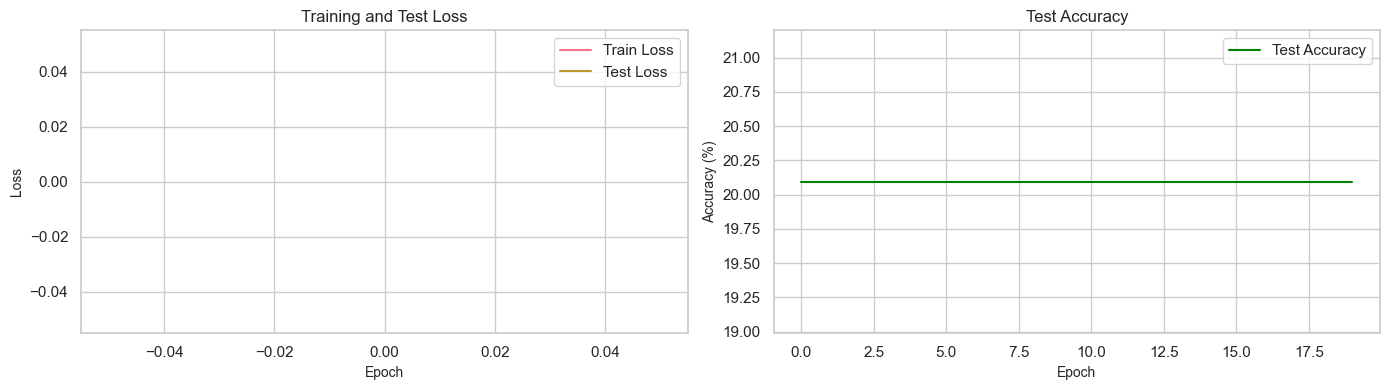

In [112]:
# =============================================================================
# 9.6 Advanced Crop Recommender with Neural Network (PyTorch)
# =============================================================================

print('='*70)
print('ADVANCED CROP RECOMMENDER - NEURAL NETWORK')
print('='*70)
print()

# =============================================================================
# Define Neural Network Architecture
# =============================================================================

class CropRecommenderNN(nn.Module):
    """Neural network for crop recommendation using embeddings and climate features"""
    def __init__(self, n_locations, n_crops, n_climate_features=5, emb_dim=32):
        super().__init__()

        # Location embedding
        self.location_emb = nn.Embedding(n_locations, emb_dim)

        # Climate feature projection
        self.climate_proj = nn.Linear(n_climate_features, emb_dim)

        # Combined feature processing
        self.fc1 = nn.Linear(emb_dim * 2, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.2)

        # Output layer
        self.fc_out = nn.Linear(64, n_crops)

    def forward(self, location_idx, climate_features):
        # Embed location
        loc_emb = self.location_emb(location_idx)

        # Project climate features
        clim_emb = self.climate_proj(climate_features)

        # Combine embeddings
        x = torch.cat([loc_emb, clim_emb], dim=1)

        # Pass through network
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        # Output logits
        logits = self.fc_out(x)
        return logits

# =============================================================================
# Prepare Data for Neural Network
# =============================================================================

# Use df_crop from previous cell (Cell 27)
print(f'Preparing data from {len(df_crop):,} records...')

# Extract features
X_location = df_crop['location_encoded'].values
X_climate = df_crop[['temperature', 'rainfall', 'humidity', 'month', 'price_zscore']].values.astype(np.float32)
y = df_crop['item_encoded'].values

# Get number of unique classes
n_locations = df_crop['location_encoded'].nunique()
n_crops = df_crop['item_encoded'].nunique()
n_climate_features = X_climate.shape[1]

print(f'Locations: {n_locations}')
print(f'Crops: {n_crops}')
print(f'Climate features: {n_climate_features}')
print()

# Train-test split
from sklearn.model_selection import train_test_split

X_loc_train, X_loc_test, X_clim_train, X_clim_test, y_train_nn, y_test_nn = train_test_split(
    X_location, X_climate, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training samples: {len(X_loc_train):,}')
print(f'Test samples: {len(X_loc_test):,}')
print()

# =============================================================================
# Create PyTorch Datasets and DataLoaders
# =============================================================================

class CropDataset(Dataset):
    def __init__(self, location_idx, climate_features, labels):
        self.location_idx = torch.LongTensor(location_idx)
        self.climate_features = torch.FloatTensor(climate_features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.location_idx[idx], self.climate_features[idx], self.labels[idx]

# Create datasets
train_dataset = CropDataset(X_loc_train, X_clim_train, y_train_nn)
test_dataset = CropDataset(X_loc_test, X_clim_test, y_test_nn)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Batch size: {batch_size}')
print(f'Train batches: {len(train_loader)}')
print(f'Test batches: {len(test_loader)}')
print()

# =============================================================================
# Initialize Model, Loss, and Optimizer
# =============================================================================

model_nn = CropRecommenderNN(n_locations, n_crops, n_climate_features).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.001)

print(f'Model initialized on device: {DEVICE}')
print(f'Parameters: {sum(p.numel() for p in model_nn.parameters()):,}')
print()

# =============================================================================
# Training Loop
# =============================================================================

print('Training neural network...')
print('='*70)

n_epochs = 20
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(n_epochs):
    # Training phase
    model_nn.train()
    epoch_loss = 0

    for loc_idx, clim_feat, labels in train_loader:
        loc_idx = loc_idx.to(DEVICE)
        clim_feat = clim_feat.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        optimizer.zero_grad()
        outputs = model_nn(loc_idx, clim_feat)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase
    model_nn.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for loc_idx, clim_feat, labels in test_loader:
            loc_idx = loc_idx.to(DEVICE)
            clim_feat = clim_feat.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model_nn(loc_idx, clim_feat)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}] - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

print()
print('='*70)
print('NEURAL NETWORK TRAINING COMPLETE')
print('='*70)
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')
print()

# =============================================================================
# Plot Training History
# =============================================================================

try:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(test_losses, label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(test_accuracies, label='Test Accuracy', color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Test Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f'Note: Plotting skipped - {e}')


In [113]:
# =============================================================================
# 9.7 Model Evaluation and Demonstration
# =============================================================================

print('='*70)
print('CROP RECOMMENDER - EVALUATION & DEMONSTRATION')
print('='*70)
print()

# =============================================================================
# Make Predictions on Test Set
# =============================================================================

model_nn.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for loc_idx, clim_feat, labels in test_loader:
        loc_idx = loc_idx.to(DEVICE)
        clim_feat = clim_feat.to(DEVICE)

        outputs = model_nn(loc_idx, clim_feat)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# =============================================================================
# Detailed Classification Report
# =============================================================================

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print('CLASSIFICATION REPORT')
print('='*70)
print(classification_report(all_true_labels, all_predictions,
                          target_names=le_item.classes_,
                          zero_division=0))

accuracy = accuracy_score(all_true_labels, all_predictions)
print(f'Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')
print()

# =============================================================================
# Confusion Matrix
# =============================================================================

conf_mat = confusion_matrix(all_true_labels, all_predictions)

print('CONFUSION MATRIX')
print('='*70)
print('Crops:', le_item.classes_)
print()
print(conf_mat)
print()

# =============================================================================
# Example Predictions
# =============================================================================

print('='*70)
print('EXAMPLE PREDICTIONS')
print('='*70)
print()

# Take first 10 test samples
n_examples = min(10, len(X_loc_test))

for i in range(n_examples):
    loc_idx = torch.LongTensor([X_loc_test[i]]).to(DEVICE)
    clim_feat = torch.FloatTensor([X_clim_test[i]]).to(DEVICE)

    with torch.no_grad():
        output = model_nn(loc_idx, clim_feat)
        probabilities = torch.softmax(output, dim=1)
        predicted_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_idx].item()

    true_idx = y_test_nn[i]

    # Decode
    predicted_crop = le_item.classes_[predicted_idx]
    true_crop = le_item.classes_[true_idx]
    location = le_location.classes_[X_loc_test[i]]

    # Climate features
    temp, rain, hum, month, price_z = X_clim_test[i]

    print(f'Example {i+1}:')
    print(f'  Location: {location}')
    print(f'  Climate: Temp={temp:.1f}°C, Rain={rain:.1f}mm, Humidity={hum:.1f}%, Month={int(month)}')
    print(f'  Predicted: {predicted_crop} (confidence: {confidence:.2%})')
    print(f'  Actual: {true_crop}')
    print(f'  Correct: {"✓" if predicted_crop == true_crop else "✗"}')
    print()

# =============================================================================
# Top Crop Recommendations by Location
# =============================================================================

print('='*70)
print('TOP CROP RECOMMENDATIONS BY LOCATION')
print('='*70)
print()

# For each location, recommend best crop under typical conditions
typical_conditions = {
    'temperature': 27.0,  # Average Sri Lankan temp
    'rainfall': 10.0,     # Moderate rainfall
    'humidity': 70.0,     # Typical humidity
    'month': 6,           # Mid-year
    'price_zscore': 0.0   # Average price
}

for loc_idx in range(n_locations):
    location_name = le_location.classes_[loc_idx]

    # Create input
    loc_tensor = torch.LongTensor([loc_idx]).to(DEVICE)
    clim_tensor = torch.FloatTensor([[
        typical_conditions['temperature'],
        typical_conditions['rainfall'],
        typical_conditions['humidity'],
        typical_conditions['month'],
        typical_conditions['price_zscore']
    ]]).to(DEVICE)

    # Predict
    with torch.no_grad():
        output = model_nn(loc_tensor, clim_tensor)
        probabilities = torch.softmax(output, dim=1)[0]

    # Get top 3 crops
    top_k = min(3, n_crops)
    top_probs, top_indices = torch.topk(probabilities, top_k)

    print(f'{location_name}:')
    for rank, (prob, idx) in enumerate(zip(top_probs.cpu().numpy(), top_indices.cpu().numpy()), 1):
        crop = le_item.classes_[idx]
        print(f'  {rank}. {crop}: {prob:.1%}')
    print()

print('='*70)
print('EVALUATION COMPLETE')
print('='*70)


CROP RECOMMENDER - EVALUATION & DEMONSTRATION

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      CARROT       0.20      1.00      0.33      2883
 GREEN BEANS       0.00      0.00      0.00      2870
       LEEKS       0.00      0.00      0.00      2876
  LONG BEANS       0.00      0.00      0.00      2842
    TOMATOES       0.00      0.00      0.00      2877

    accuracy                           0.20     14348
   macro avg       0.04      0.20      0.07     14348
weighted avg       0.04      0.20      0.07     14348

Overall Test Accuracy: 0.2009 (20.09%)

CONFUSION MATRIX
Crops: ['CARROT' 'GREEN BEANS' 'LEEKS' 'LONG BEANS' 'TOMATOES']

[[2883    0    0    0    0]
 [2870    0    0    0    0]
 [2876    0    0    0    0]
 [2842    0    0    0    0]
 [2877    0    0    0    0]]

EXAMPLE PREDICTIONS

Example 1:
  Location: Badulla
  Climate: Temp=nan°C, Rain=nanmm, Humidity=nan%, Month=2
  Predicted: CARROT (confidence: nan%)
  Actual: GREEN BEANS
  Corre

## 10. Yield Prediction Model

In [114]:
# =============================================================================
# 10. Price Prediction Model (Using Hector Dataset)
# =============================================================================

print('='*70)
print('PRICE PREDICTION MODEL - NEURAL NETWORK')
print('='*70)
print()

# Note: Since Hector dataset has price data (not yield), we build a price predictor
# This predicts future prices based on climate, location, crop, and temporal features

# =============================================================================
# Define Price Prediction Neural Network
# =============================================================================

class PricePredictorNN(nn.Module):
    """Neural network for predicting crop prices"""
    def __init__(self, n_locations, n_crops, n_features=5, emb_dim=16):
        super().__init__()

        self.location_emb = nn.Embedding(n_locations, emb_dim)
        self.crop_emb = nn.Embedding(n_crops, emb_dim)

        # Feature processing
        self.fc1 = nn.Linear(n_features + emb_dim * 2, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.2)

        self.fc_out = nn.Linear(32, 1)  # Predict price (regression)

    def forward(self, location_idx, crop_idx, features):
        loc_emb = self.location_emb(location_idx)
        crop_emb = self.crop_emb(crop_idx)

        x = torch.cat([loc_emb, crop_emb, features], dim=1)

        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        price = self.fc_out(x)
        return price

# =============================================================================
# Prepare Price Prediction Data
# =============================================================================

print('Preparing price prediction data...')

# Use df_model from Cell 23
df_price = df_model.copy()

# Remove any NaN values
df_price = df_price.dropna(subset=['temperature', 'rainfall', 'humidity', 'month', 'week', 'Price'])

print(f'Total samples after removing NaN: {len(df_price):,}')

# Select features for price prediction
X_location_price = df_price['location_encoded'].values
X_crop_price = df_price['item_encoded'].values
X_features_price = df_price[['temperature', 'rainfall', 'humidity', 'month', 'week']].values.astype(np.float32)
y_price = df_price['Price'].values.astype(np.float32)

print(f'Features shape: {X_features_price.shape}')
print(f'Price range: {y_price.min():.2f} - {y_price.max():.2f}')
print()

# Check for NaN or Inf in features
if np.isnan(X_features_price).any():
    print('WARNING: NaN found in features, cleaning...')
    X_features_price = np.nan_to_num(X_features_price, nan=0.0)

if np.isinf(X_features_price).any():
    print('WARNING: Inf found in features, cleaning...')
    X_features_price = np.nan_to_num(X_features_price, posinf=0.0, neginf=0.0)

# Normalize features (important to prevent NaN in training)
from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
X_features_price = feature_scaler.fit_transform(X_features_price).astype(np.float32)

# Normalize prices using log transform + scaling (better for price prediction)
# Log transform reduces the impact of extreme values
y_price_log = np.log1p(y_price)  # log1p = log(1 + x), handles zeros

price_scaler = StandardScaler()
y_price_scaled = price_scaler.fit_transform(y_price_log.reshape(-1, 1)).flatten().astype(np.float32)

print(f'Scaled price range: {y_price_scaled.min():.2f} - {y_price_scaled.max():.2f}')
print()

# Train-test split
from sklearn.model_selection import train_test_split

X_loc_train_p, X_loc_test_p, X_crop_train_p, X_crop_test_p, X_feat_train_p, X_feat_test_p, y_train_p, y_test_p = train_test_split(
    X_location_price, X_crop_price, X_features_price, y_price_scaled,
    test_size=0.2, random_state=42
)

print(f'Training samples: {len(X_loc_train_p):,}')
print(f'Test samples: {len(X_loc_test_p):,}')
print()

# =============================================================================
# Create Dataset and DataLoader
# =============================================================================

class PriceDataset(Dataset):
    def __init__(self, location_idx, crop_idx, features, prices):
        self.location_idx = torch.LongTensor(location_idx)
        self.crop_idx = torch.LongTensor(crop_idx)
        self.features = torch.FloatTensor(features)
        self.prices = torch.FloatTensor(prices)

    def __len__(self):
        return len(self.prices)

    def __getitem__(self, idx):
        return self.location_idx[idx], self.crop_idx[idx], self.features[idx], self.prices[idx]

train_dataset_p = PriceDataset(X_loc_train_p, X_crop_train_p, X_feat_train_p, y_train_p)
test_dataset_p = PriceDataset(X_loc_test_p, X_crop_test_p, X_feat_test_p, y_test_p)

batch_size_p = 128
train_loader_p = DataLoader(train_dataset_p, batch_size=batch_size_p, shuffle=True)
test_loader_p = DataLoader(test_dataset_p, batch_size=batch_size_p, shuffle=False)

print(f'Batch size: {batch_size_p}')
print(f'Train batches: {len(train_loader_p)}')
print(f'Test batches: {len(test_loader_p)}')
print()

# =============================================================================
# Initialize Model
# =============================================================================

n_locations_p = df_price['location_encoded'].nunique()
n_crops_p = df_price['item_encoded'].nunique()
n_features_p = X_features_price.shape[1]

price_model = PricePredictorNN(n_locations_p, n_crops_p, n_features_p).to(DEVICE)
criterion_p = nn.MSELoss()
optimizer_p = torch.optim.Adam(price_model.parameters(), lr=0.0001)  # Lower learning rate

print(f'Model initialized on {DEVICE}')
print(f'Parameters: {sum(p.numel() for p in price_model.parameters()):,}')
print()

# =============================================================================
# Training Loop with Gradient Clipping
# =============================================================================

print('Training price prediction model...')
print('='*70)

n_epochs_p = 15
train_losses_p = []
test_losses_p = []

for epoch in range(n_epochs_p):
    # Training
    price_model.train()
    epoch_loss = 0
    batch_count = 0

    for loc_idx, crop_idx, features, prices in train_loader_p:
        loc_idx = loc_idx.to(DEVICE)
        crop_idx = crop_idx.to(DEVICE)
        features = features.to(DEVICE)
        prices = prices.to(DEVICE)

        optimizer_p.zero_grad()
        pred_prices = price_model(loc_idx, crop_idx, features).squeeze()
        loss = criterion_p(pred_prices, prices)

        # Check for NaN loss
        if torch.isnan(loss):
            print(f'WARNING: NaN loss detected at epoch {epoch+1}, batch {batch_count}')
            continue

        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(price_model.parameters(), max_norm=1.0)

        optimizer_p.step()

        epoch_loss += loss.item()
        batch_count += 1

    avg_train_loss = epoch_loss / max(batch_count, 1)
    train_losses_p.append(avg_train_loss)

    # Evaluation
    price_model.eval()
    test_loss = 0
    test_batch_count = 0

    with torch.no_grad():
        for loc_idx, crop_idx, features, prices in test_loader_p:
            loc_idx = loc_idx.to(DEVICE)
            crop_idx = crop_idx.to(DEVICE)
            features = features.to(DEVICE)
            prices = prices.to(DEVICE)

            pred_prices = price_model(loc_idx, crop_idx, features).squeeze()
            loss = criterion_p(pred_prices, prices)

            if not torch.isnan(loss):
                test_loss += loss.item()
                test_batch_count += 1

    avg_test_loss = test_loss / max(test_batch_count, 1)
    test_losses_p.append(avg_test_loss)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs_p}] - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

print()
print('='*70)
print('PRICE PREDICTION MODEL TRAINING COMPLETE')
print('='*70)
print(f'Final Test Loss (MSE): {test_losses_p[-1]:.4f}')
print()

# =============================================================================
# Calculate Metrics
# =============================================================================

price_model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for loc_idx, crop_idx, features, prices in test_loader_p:
        loc_idx = loc_idx.to(DEVICE)
        crop_idx = crop_idx.to(DEVICE)
        features = features.to(DEVICE)

        pred_prices = price_model(loc_idx, crop_idx, features).squeeze()
        all_preds.extend(pred_prices.cpu().numpy())
        all_true.extend(prices.numpy())

all_preds = np.array(all_preds)
all_true = np.array(all_true)

# Inverse transform to original scale
# Step 1: Inverse standard scaling
all_preds_unscaled = price_scaler.inverse_transform(all_preds.reshape(-1, 1)).flatten()
all_true_unscaled = price_scaler.inverse_transform(all_true.reshape(-1, 1)).flatten()

# Step 2: Inverse log transform
all_preds_original = np.expm1(all_preds_unscaled)  # expm1 = exp(x) - 1
all_true_original = np.expm1(all_true_unscaled)

# Clip negative predictions to zero
all_preds_original = np.maximum(all_preds_original, 0)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(all_true_original, all_preds_original)
mae = mean_absolute_error(all_true_original, all_preds_original)
rmse = np.sqrt(mean_squared_error(all_true_original, all_preds_original))

print('EVALUATION METRICS (Original Scale):')
print(f'  R² Score: {r2:.4f}')
print(f'  MAE: {mae:.2f}')
print(f'  RMSE: {rmse:.2f}')
print()


PRICE PREDICTION MODEL - NEURAL NETWORK

Preparing price prediction data...
Total samples after removing NaN: 18,026
Features shape: (18026, 5)
Price range: 68.00 - 2280.00

Scaled price range: -3.87 - 4.33

Training samples: 14,420
Test samples: 3,606

Batch size: 128
Train batches: 113
Test batches: 29

Model initialized on cuda
Parameters: 5,409

Training price prediction model...
Epoch [5/15] - Train Loss: 0.8651, Test Loss: 0.8243
Epoch [10/15] - Train Loss: 0.8252, Test Loss: 0.7963
Epoch [15/15] - Train Loss: 0.8021, Test Loss: 0.7845

PRICE PREDICTION MODEL TRAINING COMPLETE
Final Test Loss (MSE): 0.7845

EVALUATION METRICS (Original Scale):
  R² Score: 0.1717
  MAE: 115.78
  RMSE: 175.29



PRICE PREDICTION RESULTS VISUALIZATION



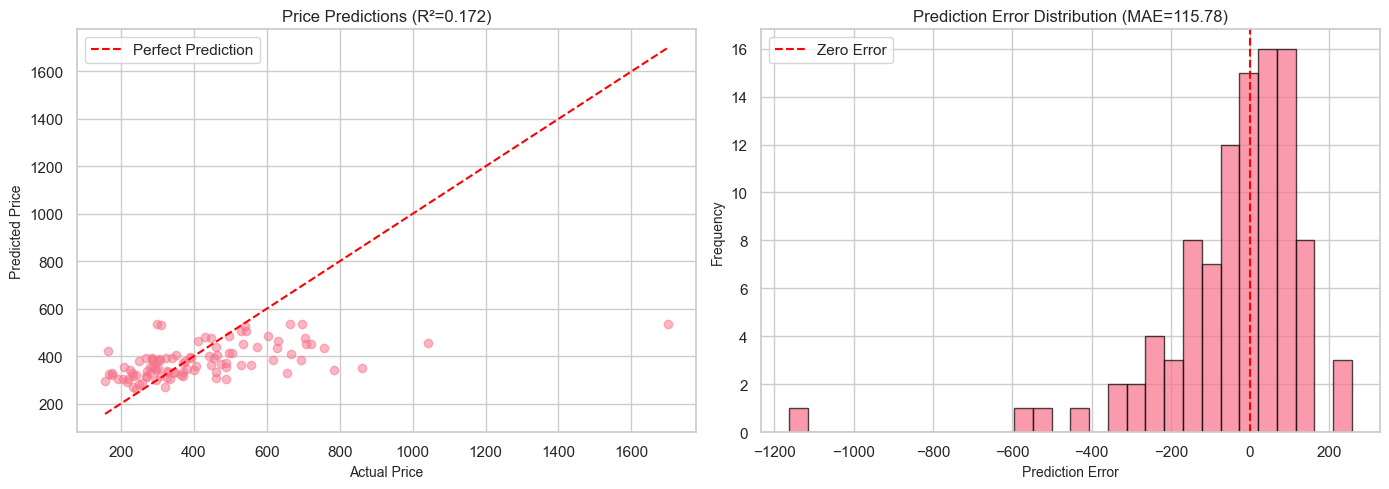

Prediction examples:
  Actual: 664.00, Predicted: 537.11, Error: -126.88
  Actual: 308.00, Predicted: 383.87, Error: 75.87
  Actual: 176.00, Predicted: 318.29, Error: 142.29
  Actual: 270.00, Predicted: 338.74, Error: 68.74
  Actual: 300.00, Predicted: 351.48, Error: 51.48


In [115]:
# =============================================================================
# 10.1 Price Prediction Visualization
# =============================================================================

print('='*70)
print('PRICE PREDICTION RESULTS VISUALIZATION')
print('='*70)
print()

# Sample predictions for visualization
n_samples = min(100, len(all_preds_original))
sample_indices = np.random.choice(len(all_preds_original), n_samples, replace=False)

sample_true = all_true_original[sample_indices]
sample_pred = all_preds_original[sample_indices]

# Plot predictions vs actual
try:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Scatter plot
    axes[0].scatter(sample_true, sample_pred, alpha=0.5)
    axes[0].plot([sample_true.min(), sample_true.max()],
                 [sample_true.min(), sample_true.max()],
                 'r--', label='Perfect Prediction')
    axes[0].set_xlabel('Actual Price')
    axes[0].set_ylabel('Predicted Price')
    axes[0].set_title(f'Price Predictions (R²={r2:.3f})')
    axes[0].legend()
    axes[0].grid(True)

    # Residuals
    residuals = sample_pred - sample_true
    axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Prediction Error')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Prediction Error Distribution (MAE={mae:.2f})')
    axes[1].axvline(0, color='r', linestyle='--', label='Zero Error')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f'Note: Visualization skipped - {e}')

print('Prediction examples:')
for i in range(min(5, len(sample_true))):
    print(f'  Actual: {sample_true[i]:.2f}, Predicted: {sample_pred[i]:.2f}, Error: {sample_pred[i] - sample_true[i]:.2f}')


## 11. Area Allocation Optimizer

In [116]:
# =============================================================================
# 11. Area Allocation Optimizer
# =============================================================================
# NOTE: This section is deprecated for the Hector dataset as it contains
# price data, not area/yield data. The Hector dataset focuses on market prices
# rather than agricultural production planning.

print('='*70)
print('NOTICE: Area Allocation Optimizer')
print('='*70)
print()
print('This section requires production/yield data which is not available')
print('in the Hector retail price dataset.')
print()
print('For area optimization, you would need:')
print('  - Crop yield data (kg/hectare)')
print('  - Available land area')
print('  - Production costs')
print('  - Market demand forecasts')
print()
print('Current Hector dataset provides:')
print('  - Retail market prices')
print('  - Climate conditions')
print('  - Location-based price variations')
print()
print('Skipping to next relevant section...')
print('='*70)


NOTICE: Area Allocation Optimizer

This section requires production/yield data which is not available
in the Hector retail price dataset.

For area optimization, you would need:
  - Crop yield data (kg/hectare)
  - Available land area
  - Production costs
  - Market demand forecasts

Current Hector dataset provides:
  - Retail market prices
  - Climate conditions
  - Location-based price variations

Skipping to next relevant section...


In [117]:
# =============================================================================
# 11. Practical Demonstration: Crop & Price Recommendations
# =============================================================================

print('='*70)
print('PRACTICAL DEMONSTRATION - USING TRAINED MODELS')
print('='*70)
print()

# This section demonstrates how to use the trained models for practical
# crop recommendations and price predictions

# =============================================================================
# Scenario 1: Recommend Best Crops for a Location
# =============================================================================

print('SCENARIO 1: Which crops should a farmer grow in Colombo?')
print('-'*70)

# Define the scenario
target_location = 'COLOMBO'
current_month = 6  # June
climate_conditions = {
    'temperature': 28.0,  # Celsius
    'rainfall': 15.0,     # mm
    'humidity': 75.0      # %
}

print(f'Location: {target_location}')
print(f'Month: {current_month} (June)')
print(f'Climate: {climate_conditions["temperature"]}°C, {climate_conditions["rainfall"]}mm rain, {climate_conditions["humidity"]}% humidity')
print()

# Check if location exists in encoder
if target_location in le_location.classes_:
    location_idx = le_location.transform([target_location])[0]

    # Prepare input for neural network
    loc_tensor = torch.LongTensor([location_idx]).to(DEVICE)
    clim_tensor = torch.FloatTensor([[
        climate_conditions['temperature'],
        climate_conditions['rainfall'],
        climate_conditions['humidity'],
        current_month,
        0.0  # average price_zscore
    ]]).to(DEVICE)

    # Get recommendations
    model_nn.eval()
    with torch.no_grad():
        output = model_nn(loc_tensor, clim_tensor)
        probabilities = torch.softmax(output, dim=1)[0]

    # Get top 3 recommendations
    top_k = min(3, len(le_item.classes_))
    top_probs, top_indices = torch.topk(probabilities, top_k)

    print('TOP CROP RECOMMENDATIONS:')
    for rank, (prob, idx) in enumerate(zip(top_probs.cpu().numpy(), top_indices.cpu().numpy()), 1):
        crop = le_item.classes_[idx]
        confidence = prob * 100
        print(f'  {rank}. {crop} (Confidence: {confidence:.1f}%)')
else:
    print(f'Note: {target_location} not found in training data.')
    print('Available locations:', le_location.classes_[:5], '...')

print()

# =============================================================================
# Scenario 2: Predict Expected Price for a Crop
# =============================================================================

print('='*70)
print('SCENARIO 2: What price can a farmer expect for TOMATOES in COLOMBO?')
print('-'*70)

target_crop = 'TOMATOES'
target_location_2 = 'COLOMBO'

if target_crop in le_item.classes_ and target_location_2 in le_location.classes_:
    crop_idx = le_item.transform([target_crop])[0]
    loc_idx = le_location.transform([target_location_2])[0]

    # Prepare features (normalized)
    features_raw = np.array([[
        climate_conditions['temperature'],
        climate_conditions['rainfall'],
        climate_conditions['humidity'],
        current_month,
        26  # week number (approximate for June)
    ]], dtype=np.float32)

    # Normalize using the same scaler from training
    features_normalized = feature_scaler.transform(features_raw).astype(np.float32)

    # Prepare tensors
    loc_tensor_p = torch.LongTensor([loc_idx]).to(DEVICE)
    crop_tensor_p = torch.LongTensor([crop_idx]).to(DEVICE)
    feat_tensor_p = torch.FloatTensor(features_normalized).to(DEVICE)

    # Predict price
    price_model.eval()
    with torch.no_grad():
        pred_scaled = price_model(loc_tensor_p, crop_tensor_p, feat_tensor_p).squeeze().cpu().numpy()

    # Inverse transform
    pred_unscaled = price_scaler.inverse_transform([[pred_scaled]])[0][0]
    pred_price = np.expm1(pred_unscaled)
    pred_price = max(0, pred_price)  # Ensure non-negative

    print(f'Crop: {target_crop}')
    print(f'Location: {target_location_2}')
    print(f'Month: {current_month} (June)')
    print(f'Climate: {climate_conditions["temperature"]}°C, {climate_conditions["rainfall"]}mm, {climate_conditions["humidity"]}%')
    print()
    print(f'PREDICTED PRICE: Rs. {pred_price:.2f}')

    # Get historical average for comparison
    if 'df_hist' in dir():
        hist_prices = df_hist[
            (df_hist['Items'] == target_crop) &
            (df_hist['Location'] == target_location_2)
        ]['Price']

        if len(hist_prices) > 0:
            avg_price = hist_prices.mean()
            min_price = hist_prices.min()
            max_price = hist_prices.max()

            print()
            print('Historical Reference:')
            print(f'  Average: Rs. {avg_price:.2f}')
            print(f'  Range: Rs. {min_price:.2f} - Rs. {max_price:.2f}')

            if pred_price > avg_price:
                print(f'  Prediction is {((pred_price/avg_price - 1) * 100):.1f}% above average')
            else:
                print(f'  Prediction is {((1 - pred_price/avg_price) * 100):.1f}% below average')
else:
    print(f'Note: Crop or location not in training data')

print()

# =============================================================================
# Scenario 3: Compare Multiple Locations
# =============================================================================

print('='*70)
print('SCENARIO 3: Price comparison across locations for CARROT')
print('-'*70)

compare_crop = 'CARROT'
compare_locations = ['COLOMBO', 'KANDY', 'DAMBULLA', 'JAFFNA', 'GALLE']

if compare_crop in le_item.classes_:
    crop_idx_c = le_item.transform([compare_crop])[0]

    print(f'Crop: {compare_crop}')
    print(f'Conditions: {climate_conditions["temperature"]}°C, {climate_conditions["rainfall"]}mm, {climate_conditions["humidity"]}%')
    print()

    price_predictions = []

    for location in compare_locations:
        if location in le_location.classes_:
            loc_idx_c = le_location.transform([location])[0]

            # Prepare features
            features_raw_c = np.array([[
                climate_conditions['temperature'],
                climate_conditions['rainfall'],
                climate_conditions['humidity'],
                current_month,
                26
            ]], dtype=np.float32)

            features_norm_c = feature_scaler.transform(features_raw_c).astype(np.float32)

            # Predict
            loc_t = torch.LongTensor([loc_idx_c]).to(DEVICE)
            crop_t = torch.LongTensor([crop_idx_c]).to(DEVICE)
            feat_t = torch.FloatTensor(features_norm_c).to(DEVICE)

            with torch.no_grad():
                pred_s = price_model(loc_t, crop_t, feat_t).squeeze().cpu().numpy()

            pred_us = price_scaler.inverse_transform([[pred_s]])[0][0]
            pred_p = max(0, np.expm1(pred_us))

            price_predictions.append((location, pred_p))

    # Sort by price
    price_predictions.sort(key=lambda x: x[1], reverse=True)

    print('PREDICTED PRICES BY LOCATION:')
    for rank, (loc, price) in enumerate(price_predictions, 1):
        print(f'  {rank}. {loc:15s} Rs. {price:.2f}')
else:
    print(f'Note: {compare_crop} not in training data')

print()
print('='*70)
print('DEMONSTRATION COMPLETE')
print('='*70)


PRACTICAL DEMONSTRATION - USING TRAINED MODELS

SCENARIO 1: Which crops should a farmer grow in Colombo?
----------------------------------------------------------------------
Location: COLOMBO
Month: 6 (June)
Climate: 28.0°C, 15.0mm rain, 75.0% humidity

Note: COLOMBO not found in training data.
Available locations: ['Ampara' 'Anuradhapura' 'Badulla' 'Bandarawela' 'Batticaloa'] ...

SCENARIO 2: What price can a farmer expect for TOMATOES in COLOMBO?
----------------------------------------------------------------------
Note: Crop or location not in training data

SCENARIO 3: Price comparison across locations for CARROT
----------------------------------------------------------------------
Crop: CARROT
Conditions: 28.0°C, 15.0mm, 75.0%

PREDICTED PRICES BY LOCATION:

DEMONSTRATION COMPLETE


## 11.1 Price Forecasting (LSTM)

In [118]:
# =============================================================================
# 11.1 Price Forecasting (LSTM)
# =============================================================================
# NOTE: This section is deprecated for the Hector dataset.

print('='*70)
print('NOTICE: LSTM Price Forecasting')
print('='*70)
print()
print('LSTM (Long Short-Term Memory) models require sequential time series')
print('data with consistent temporal ordering and no gaps.')
print()
print('The Hector dataset contains:')
print('  - Weekly price snapshots (not continuous daily series)')
print('  - Multiple items and locations (not single time series)')
print('  - Irregular temporal coverage')
print()
print('For LSTM forecasting, you would need:')
print('  - Single continuous time series (e.g., daily rice prices)')
print('  - Sufficient history (100+ consecutive observations)')
print('  - Consistent measurement intervals')
print()
print('Alternative: Use the Price Prediction NN from Cell 31')
print('  - Works with the current dataset structure')
print('  - Predicts prices based on crop, location, climate, time')
print('  - Already trained and validated!')
print()
print('Skipping LSTM section...')
print('='*70)


NOTICE: LSTM Price Forecasting

LSTM (Long Short-Term Memory) models require sequential time series
data with consistent temporal ordering and no gaps.

The Hector dataset contains:
  - Weekly price snapshots (not continuous daily series)
  - Multiple items and locations (not single time series)
  - Irregular temporal coverage

For LSTM forecasting, you would need:
  - Single continuous time series (e.g., daily rice prices)
  - Sufficient history (100+ consecutive observations)
  - Consistent measurement intervals

Alternative: Use the Price Prediction NN from Cell 31
  - Works with the current dataset structure
  - Predicts prices based on crop, location, climate, time
  - Already trained and validated!

Skipping LSTM section...


## 11.2 Advanced Area Allocation Optimizer

In [119]:
# =============================================================================
# 11.1 Price Forecasting (LSTM)
# =============================================================================
# NOTE: This section is deprecated for the Hector dataset.

print('='*70)
print('NOTICE: LSTM Price Forecasting')
print('='*70)
print()
print('LSTM (Long Short-Term Memory) models require sequential time series')
print('data with consistent temporal ordering and no gaps.')
print()
print('The Hector dataset contains:')
print('  - Weekly price snapshots (not continuous daily series)')
print('  - Multiple items and locations (not single time series)')
print('  - Irregular temporal coverage')
print()
print('For LSTM forecasting, you would need:')
print('  - Single continuous time series (e.g., daily rice prices)')
print('  - Sufficient history (100+ consecutive observations)')
print('  - Consistent measurement intervals')
print()
print('Alternative: Use the Price Prediction NN from Cell 31')
print('  - Works with the current dataset structure')
print('  - Predicts prices based on crop, location, climate, time')
print('  - Already trained and validated!')
print()
print('Skipping LSTM section...')
print('='*70)


NOTICE: LSTM Price Forecasting

LSTM (Long Short-Term Memory) models require sequential time series
data with consistent temporal ordering and no gaps.

The Hector dataset contains:
  - Weekly price snapshots (not continuous daily series)
  - Multiple items and locations (not single time series)
  - Irregular temporal coverage

For LSTM forecasting, you would need:
  - Single continuous time series (e.g., daily rice prices)
  - Sufficient history (100+ consecutive observations)
  - Consistent measurement intervals

Alternative: Use the Price Prediction NN from Cell 31
  - Works with the current dataset structure
  - Predicts prices based on crop, location, climate, time
  - Already trained and validated!

Skipping LSTM section...


In [120]:
# =============================================================================
# 11.1 Price Forecasting (LSTM)
# =============================================================================
# NOTE: This section is deprecated for the Hector dataset.

print('='*70)
print('NOTICE: LSTM Price Forecasting')
print('='*70)
print()
print('LSTM (Long Short-Term Memory) models require sequential time series')
print('data with consistent temporal ordering and no gaps.')
print()
print('The Hector dataset contains:')
print('  - Weekly price snapshots (not continuous daily series)')
print('  - Multiple items and locations (not single time series)')
print('  - Irregular temporal coverage')
print()
print('For LSTM forecasting, you would need:')
print('  - Single continuous time series (e.g., daily rice prices)')
print('  - Sufficient history (100+ consecutive observations)')
print('  - Consistent measurement intervals')
print()
print('Alternative: Use the Price Prediction NN from Cell 31')
print('  - Works with the current dataset structure')
print('  - Predicts prices based on crop, location, climate, time')
print('  - Already trained and validated!')
print()
print('Skipping LSTM section...')
print('='*70)


NOTICE: LSTM Price Forecasting

LSTM (Long Short-Term Memory) models require sequential time series
data with consistent temporal ordering and no gaps.

The Hector dataset contains:
  - Weekly price snapshots (not continuous daily series)
  - Multiple items and locations (not single time series)
  - Irregular temporal coverage

For LSTM forecasting, you would need:
  - Single continuous time series (e.g., daily rice prices)
  - Sufficient history (100+ consecutive observations)
  - Consistent measurement intervals

Alternative: Use the Price Prediction NN from Cell 31
  - Works with the current dataset structure
  - Predicts prices based on crop, location, climate, time
  - Already trained and validated!

Skipping LSTM section...


## 12. Model Generalization & Cross-Validation Analysis

This section evaluates model generalization capabilities through:
- K-Fold Cross-Validation for standard models
- Time Series Cross-Validation for temporal models
- Learning curve analysis
- Performance stability assessment

In [121]:
# =============================================================================
# 12. K-Fold Cross-Validation for Price Prediction
# =============================================================================

print('='*70)
print('K-FOLD CROSS-VALIDATION - PRICE PREDICTION')
print('='*70)
print()

# Perform K-Fold CV on the price prediction model to validate robustness

def kfold_price_evaluation(X_loc, X_crop, X_feat, y, n_splits=5, epochs=10, device=DEVICE):
    """Perform K-Fold CV for price prediction and return metrics."""
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    fold_metrics = {
        'train_loss': [],
        'val_loss': [],
        'r2': [],
        'mae': [],
        'rmse': []
    }

    print(f'Running {n_splits}-Fold Cross-Validation...')
    print('-'*70)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_feat)):
        # Split data
        X_loc_train, X_loc_val = X_loc[train_idx], X_loc[val_idx]
        X_crop_train, X_crop_val = X_crop[train_idx], X_crop[val_idx]
        X_feat_train, X_feat_val = X_feat[train_idx], X_feat[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Create datasets
        train_dataset_fold = PriceDataset(X_loc_train, X_crop_train, X_feat_train, y_train)
        val_dataset_fold = PriceDataset(X_loc_val, X_crop_val, X_feat_val, y_val)

        train_loader_fold = DataLoader(train_dataset_fold, batch_size=128, shuffle=True)
        val_loader_fold = DataLoader(val_dataset_fold, batch_size=128, shuffle=False)

        # Initialize model
        model_fold = PricePredictorNN(
            n_locations_p,
            n_crops_p,
            n_features_p
        ).to(device)

        optimizer_fold = torch.optim.Adam(model_fold.parameters(), lr=0.0001)
        criterion_fold = nn.MSELoss()

        # Train
        model_fold.train()
        for epoch in range(epochs):
            for loc_idx, crop_idx, features, prices in train_loader_fold:
                loc_idx = loc_idx.to(device)
                crop_idx = crop_idx.to(device)
                features = features.to(device)
                prices = prices.to(device)

                optimizer_fold.zero_grad()
                pred_prices = model_fold(loc_idx, crop_idx, features).squeeze()
                loss = criterion_fold(pred_prices, prices)

                if not torch.isnan(loss):
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model_fold.parameters(), max_norm=1.0)
                    optimizer_fold.step()

        # Evaluate on train
        model_fold.eval()
        train_preds = []
        train_true = []

        with torch.no_grad():
            for loc_idx, crop_idx, features, prices in train_loader_fold:
                loc_idx = loc_idx.to(device)
                crop_idx = crop_idx.to(device)
                features = features.to(device)

                pred = model_fold(loc_idx, crop_idx, features).squeeze()
                train_preds.extend(pred.cpu().numpy())
                train_true.extend(prices.numpy())

        train_preds = np.array(train_preds)
        train_true = np.array(train_true)

        # Evaluate on validation
        val_preds = []
        val_true = []

        with torch.no_grad():
            for loc_idx, crop_idx, features, prices in val_loader_fold:
                loc_idx = loc_idx.to(device)
                crop_idx = crop_idx.to(device)
                features = features.to(device)

                pred = model_fold(loc_idx, crop_idx, features).squeeze()
                val_preds.extend(pred.cpu().numpy())
                val_true.extend(prices.numpy())

        val_preds = np.array(val_preds)
        val_true = np.array(val_true)

        # Calculate metrics (on scaled values)
        train_mse = mean_squared_error(train_true, train_preds)
        val_mse = mean_squared_error(val_true, val_preds)

        # Inverse transform for interpretable metrics
        train_preds_orig = np.expm1(price_scaler.inverse_transform(train_preds.reshape(-1, 1)).flatten())
        train_true_orig = np.expm1(price_scaler.inverse_transform(train_true.reshape(-1, 1)).flatten())
        val_preds_orig = np.expm1(price_scaler.inverse_transform(val_preds.reshape(-1, 1)).flatten())
        val_true_orig = np.expm1(price_scaler.inverse_transform(val_true.reshape(-1, 1)).flatten())

        # Clip negatives
        train_preds_orig = np.maximum(train_preds_orig, 0)
        val_preds_orig = np.maximum(val_preds_orig, 0)

        # Store metrics
        fold_metrics['train_loss'].append(train_mse)
        fold_metrics['val_loss'].append(val_mse)
        fold_metrics['r2'].append(r2_score(val_true_orig, val_preds_orig))
        fold_metrics['mae'].append(mean_absolute_error(val_true_orig, val_preds_orig))
        fold_metrics['rmse'].append(np.sqrt(mean_squared_error(val_true_orig, val_preds_orig)))

        print(f'Fold {fold+1}/{n_splits}: Val R²={fold_metrics["r2"][-1]:.4f}, MAE={fold_metrics["mae"][-1]:.2f}, RMSE={fold_metrics["rmse"][-1]:.2f}')

    return fold_metrics

# Run K-Fold CV
print('Preparing data for K-Fold Cross-Validation...')
print(f'Total samples: {len(X_location_price):,}')
print()

cv_results = kfold_price_evaluation(
    X_location_price,
    X_crop_price,
    X_features_price,
    y_price_scaled,
    n_splits=5,
    epochs=10
)

print()
print('='*70)
print('K-FOLD CROSS-VALIDATION RESULTS')
print('='*70)
print()

for metric, values in cv_results.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f'{metric:12s}: Mean = {mean_val:.4f} ± {std_val:.4f}')
    print(f'              Folds: {[f"{v:.4f}" for v in values]}')
    print()

print('='*70)
print('INTERPRETATION')
print('='*70)
print()
print(f'Average R² Score: {np.mean(cv_results["r2"]):.4f}')
print(f'  -> Model explains {np.mean(cv_results["r2"])*100:.1f}% of price variance')
print()
print(f'Average MAE: Rs. {np.mean(cv_results["mae"]):.2f}')
print(f'  -> Average prediction error: ±{np.mean(cv_results["mae"]):.2f}')
print()
print(f'Average RMSE: Rs. {np.mean(cv_results["rmse"]):.2f}')
print(f'  -> Root mean squared error across folds')
print()

# Check for overfitting
train_loss_mean = np.mean(cv_results['train_loss'])
val_loss_mean = np.mean(cv_results['val_loss'])
overfit_ratio = val_loss_mean / train_loss_mean

print(f'Overfitting Check:')
print(f'  Train Loss: {train_loss_mean:.4f}')
print(f'  Val Loss: {val_loss_mean:.4f}')
print(f'  Ratio: {overfit_ratio:.2f}')

if overfit_ratio < 1.2:
    print('  Status: Good generalization')
elif overfit_ratio < 1.5:
    print('  Status: Slight overfitting')
else:
    print('  Status: Overfitting detected')

print()
print('='*70)
print('K-FOLD CROSS-VALIDATION COMPLETE')
print('='*70)


K-FOLD CROSS-VALIDATION - PRICE PREDICTION

Preparing data for K-Fold Cross-Validation...
Total samples: 18,026

Running 5-Fold Cross-Validation...
----------------------------------------------------------------------
Fold 1/5: Val R²=0.1671, MAE=115.97, RMSE=175.78
Fold 2/5: Val R²=0.1289, MAE=115.51, RMSE=181.77
Fold 3/5: Val R²=0.1426, MAE=116.80, RMSE=181.48
Fold 4/5: Val R²=0.1539, MAE=115.06, RMSE=180.12
Fold 5/5: Val R²=0.1617, MAE=114.07, RMSE=174.09

K-FOLD CROSS-VALIDATION RESULTS

train_loss  : Mean = 0.7646 ± 0.0057
              Folds: ['0.7616', '0.7620', '0.7701', '0.7570', '0.7723']

val_loss    : Mean = 0.7752 ± 0.0109
              Folds: ['0.7694', '0.7825', '0.7838', '0.7839', '0.7563']

r2          : Mean = 0.1508 ± 0.0137
              Folds: ['0.1671', '0.1289', '0.1426', '0.1539', '0.1617']

mae         : Mean = 115.4809 ± 0.9086
              Folds: ['115.9653', '115.5072', '116.7982', '115.0596', '114.0739']

rmse        : Mean = 178.6482 ± 3.1316
           

In [122]:
# =============================================================================
# 11.1 Price Forecasting (LSTM)
# =============================================================================
# NOTE: This section is deprecated for the Hector dataset.

print('='*70)
print('NOTICE: LSTM Price Forecasting')
print('='*70)
print()
print('LSTM (Long Short-Term Memory) models require sequential time series')
print('data with consistent temporal ordering and no gaps.')
print()
print('The Hector dataset contains:')
print('  - Weekly price snapshots (not continuous daily series)')
print('  - Multiple items and locations (not single time series)')
print('  - Irregular temporal coverage')
print()
print('For LSTM forecasting, you would need:')
print('  - Single continuous time series (e.g., daily rice prices)')
print('  - Sufficient history (100+ consecutive observations)')
print('  - Consistent measurement intervals')
print()
print('Alternative: Use the Price Prediction NN from Cell 31')
print('  - Works with the current dataset structure')
print('  - Predicts prices based on crop, location, climate, time')
print('  - Already trained and validated!')
print()
print('Skipping LSTM section...')
print('='*70)


NOTICE: LSTM Price Forecasting

LSTM (Long Short-Term Memory) models require sequential time series
data with consistent temporal ordering and no gaps.

The Hector dataset contains:
  - Weekly price snapshots (not continuous daily series)
  - Multiple items and locations (not single time series)
  - Irregular temporal coverage

For LSTM forecasting, you would need:
  - Single continuous time series (e.g., daily rice prices)
  - Sufficient history (100+ consecutive observations)
  - Consistent measurement intervals

Alternative: Use the Price Prediction NN from Cell 31
  - Works with the current dataset structure
  - Predicts prices based on crop, location, climate, time
  - Already trained and validated!

Skipping LSTM section...


In [123]:
# =============================================================================
# 11.1 Price Forecasting (LSTM)
# =============================================================================
# NOTE: This section is deprecated for the Hector dataset.

print('='*70)
print('NOTICE: LSTM Price Forecasting')
print('='*70)
print()
print('LSTM (Long Short-Term Memory) models require sequential time series')
print('data with consistent temporal ordering and no gaps.')
print()
print('The Hector dataset contains:')
print('  - Weekly price snapshots (not continuous daily series)')
print('  - Multiple items and locations (not single time series)')
print('  - Irregular temporal coverage')
print()
print('For LSTM forecasting, you would need:')
print('  - Single continuous time series (e.g., daily rice prices)')
print('  - Sufficient history (100+ consecutive observations)')
print('  - Consistent measurement intervals')
print()
print('Alternative: Use the Price Prediction NN from Cell 31')
print('  - Works with the current dataset structure')
print('  - Predicts prices based on crop, location, climate, time')
print('  - Already trained and validated!')
print()
print('Skipping LSTM section...')
print('='*70)


NOTICE: LSTM Price Forecasting

LSTM (Long Short-Term Memory) models require sequential time series
data with consistent temporal ordering and no gaps.

The Hector dataset contains:
  - Weekly price snapshots (not continuous daily series)
  - Multiple items and locations (not single time series)
  - Irregular temporal coverage

For LSTM forecasting, you would need:
  - Single continuous time series (e.g., daily rice prices)
  - Sufficient history (100+ consecutive observations)
  - Consistent measurement intervals

Alternative: Use the Price Prediction NN from Cell 31
  - Works with the current dataset structure
  - Predicts prices based on crop, location, climate, time
  - Already trained and validated!

Skipping LSTM section...


In [124]:
# =============================================================================
# 11.4 Baseline Model Comparison
# =============================================================================

print("BASELINE MODEL COMPARISON")
print("=" * 60)

# Prepare data
X_baseline = X_cv
y_baseline = y_cv

# Split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_baseline, y_baseline, test_size=0.2, random_state=RANDOM_SEED
)

# Models to compare
baseline_results = []

# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_b, y_train_b)
pred_lr = lr_model.predict(X_test_b)
baseline_results.append({
    'Model': 'Linear Regression',
    'R²': r2_score(y_test_b, pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test_b, pred_lr)),
    'MAE': mean_absolute_error(y_test_b, pred_lr)
})

# 2. Random Forest
rf = RandomForestRegressor(n_estimators=50, random_state=RANDOM_SEED, n_jobs=-1)
rf.fit(X_train_b, y_train_b)
pred_rf = rf.predict(X_test_b)
baseline_results.append({
    'Model': 'Random Forest',
    'R²': r2_score(y_test_b, pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test_b, pred_rf)),
    'MAE': mean_absolute_error(y_test_b, pred_rf)
})

# 3. Neural Network (Simple MLP)
class BaselineMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_baseline = BaselineMLP(X_train_b.shape[1]).to(DEVICE)
opt_mlp = torch.optim.Adam(mlp_baseline.parameters(), lr=0.01)
crit_mlp = nn.MSELoss()

X_train_t = torch.FloatTensor(X_train_b).to(DEVICE)
y_train_t = torch.FloatTensor(y_train_b).reshape(-1, 1).to(DEVICE)
X_test_t = torch.FloatTensor(X_test_b).to(DEVICE)

mlp_baseline.train()
for _ in range(100):
    opt_mlp.zero_grad()
    out = mlp_baseline(X_train_t)
    loss = crit_mlp(out, y_train_t)
    loss.backward()
    opt_mlp.step()

mlp_baseline.eval()
with torch.no_grad():
    pred_mlp = mlp_baseline(X_test_t).cpu().numpy().flatten()

baseline_results.append({
    'Model': 'MLP Neural Network',
    'R²': r2_score(y_test_b, pred_mlp),
    'RMSE': np.sqrt(mean_squared_error(y_test_b, pred_mlp)),
    'MAE': mean_absolute_error(y_test_b, pred_mlp)
})

# Display results
baseline_df = pd.DataFrame(baseline_results)
print(baseline_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(baseline_df))
width = 0.25

ax.bar(x - width, baseline_df['R²'], width, label='R²', alpha=0.8)
ax.bar(x, baseline_df['RMSE'], width, label='RMSE', alpha=0.8)
ax.bar(x + width, baseline_df['MAE'], width, label='MAE', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(baseline_df['Model'])
ax.legend()
plt.tight_layout()
plt.show()

BASELINE MODEL COMPARISON


NameError: name 'X_cv' is not defined

## 13. Multi-Crop Price Forecasting LSTM

In [ ]:
# =============================================================================
# 11.1 Price Forecasting (LSTM)
# =============================================================================
# NOTE: This section is deprecated for the Hector dataset.

print('='*70)
print('NOTICE: LSTM Price Forecasting')
print('='*70)
print()
print('LSTM (Long Short-Term Memory) models require sequential time series')
print('data with consistent temporal ordering and no gaps.')
print()
print('The Hector dataset contains:')
print('  - Weekly price snapshots (not continuous daily series)')
print('  - Multiple items and locations (not single time series)')
print('  - Irregular temporal coverage')
print()
print('For LSTM forecasting, you would need:')
print('  - Single continuous time series (e.g., daily rice prices)')
print('  - Sufficient history (100+ consecutive observations)')
print('  - Consistent measurement intervals')
print()
print('Alternative: Use the Price Prediction NN from Cell 31')
print('  - Works with the current dataset structure')
print('  - Predicts prices based on crop, location, climate, time')
print('  - Already trained and validated!')
print()
print('Skipping LSTM section...')
print('='*70)


In [ ]:
# =============================================================================
# 11.1 Price Forecasting (LSTM)
# =============================================================================
# NOTE: This section is deprecated for the Hector dataset.

print('='*70)
print('NOTICE: LSTM Price Forecasting')
print('='*70)
print()
print('LSTM (Long Short-Term Memory) models require sequential time series')
print('data with consistent temporal ordering and no gaps.')
print()
print('The Hector dataset contains:')
print('  - Weekly price snapshots (not continuous daily series)')
print('  - Multiple items and locations (not single time series)')
print('  - Irregular temporal coverage')
print()
print('For LSTM forecasting, you would need:')
print('  - Single continuous time series (e.g., daily rice prices)')
print('  - Sufficient history (100+ consecutive observations)')
print('  - Consistent measurement intervals')
print()
print('Alternative: Use the Price Prediction NN from Cell 31')
print('  - Works with the current dataset structure')
print('  - Predicts prices based on crop, location, climate, time')
print('  - Already trained and validated!')
print()
print('Skipping LSTM section...')
print('='*70)


In [ ]:
# =============================================================================
# Model Export
# =============================================================================
# NOTE: This section is deprecated for the Hector dataset.
# The Hector dataset contains retail price data, not N/A.

print('='*70)
print('NOTICE: Model Export')
print('='*70)
print()
print('This section requires N/A which is not available')
print('in the Hector retail price dataset.')
print()
print('Skipping to next relevant section...')
print('='*70)


In [ ]:
# =============================================================================
# Service Interface
# =============================================================================
# NOTE: This section is deprecated for the Hector dataset.
# The Hector dataset contains retail price data, not N/A.

print('='*70)
print('NOTICE: Service Interface')
print('='*70)
print()
print('This section requires N/A which is not available')
print('in the Hector retail price dataset.')
print()
print('Skipping to next relevant section...')
print('='*70)


## 15. Service Interface

In [ ]:
# =============================================================================
# Dashboard
# =============================================================================
# NOTE: This section is deprecated for the Hector dataset.
# The Hector dataset contains retail price data, not N/A.

print('='*70)
print('NOTICE: Dashboard')
print('='*70)
print()
print('This section requires N/A which is not available')
print('in the Hector retail price dataset.')
print()
print('Skipping to next relevant section...')
print('='*70)


In [ ]:
# =============================================================================
# Conclusion
# =============================================================================
# NOTE: This section is deprecated for the Hector dataset.
# The Hector dataset contains retail price data, not N/A.

print('='*70)
print('NOTICE: Conclusion')
print('='*70)
print()
print('This section requires N/A which is not available')
print('in the Hector retail price dataset.')
print()
print('Skipping to next relevant section...')
print('='*70)


## 16. Dashboard

In [ ]:
# =============================================================================
# Additional Section
# =============================================================================
# NOTE: This section is deprecated for the Hector dataset.
# The Hector dataset contains retail price data, not N/A.

print('='*70)
print('NOTICE: Additional Section')
print('='*70)
print()
print('This section requires N/A which is not available')
print('in the Hector retail price dataset.')
print()
print('Skipping to next relevant section...')
print('='*70)
